**1. Importing libraries**

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd

np.seterr(divide='ignore', invalid='ignore')

plt.rcParams.update({
#     "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
plt.rcParams['font.size'] = 14
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib notebook

**2. Constants**

In [2]:
h2ev = 27.21184 # Hartree, converts Hartree to eV
a0 = 0.529177 # Bohr Radius in Angstroem
hc = 12.3981756608 # planck constant times velocity of light keV Angstr
r0 = 2.8179403227e-15
machine_eps = np.finfo('float64').eps
xraypath = '/Users/olgaridzel/Research/Bruce/PHYSDAT/opt/xray/' # provide the full path to the dir with the Henke data (download from https://henke.lbl.gov/optical_constants/asf.html)

**3. Creating the Osc class**

In [3]:
class Osc:
    name = '' # material name
    composition = {} # alloy configuration, e.g. for SiO2 {{element: 'si', index: 1}, {element: 'o', index: 2}}
    model = '' # model name
    omega = None # list of binding energies
    A = None # list of amplitudes
    gamma = None # list of damping coefficients
    alpha = 1.0 # alpha is a constant between 1 (metals) and 0 (insulators)
    Eg = 0.0 # the band gap energy
    Ef = 0.0 # the Fermi energy
    eps_b = 1.0 # the background dielectric constant due to the polarizability of the core electrons
    eloss = None # energy loss range
    q = None # momentum transfer range
    vb = 0.0 # the width of the valence band
    na = 0.0 # atomic density

**4. Defining the functions**

In [4]:
def linspace(start, stop, step=1.):
    num = int((stop - start) / step + 1)
    return np.linspace(start, stop, num)

def convert2au(osc):
    if osc.model == 'Drude':
        osc.A = osc.A/h2ev/h2ev
    osc.gamma = osc.gamma/h2ev
    osc.omega = osc.omega/h2ev
    osc.Ef = osc.Ef/h2ev
    osc.eloss = osc.eloss/h2ev
    osc.q = osc.q*a0
    if hasattr(osc,'Eg'):
        osc.Eg = osc.Eg/h2ev
    if hasattr(osc,'vb'):
        osc.vb = osc.vb/h2ev

def convert2ru(osc):
    if osc.model == 'Drude':
        osc.A = osc.A*h2ev*h2ev
    osc.gamma = osc.gamma*h2ev
    osc.omega = osc.omega*h2ev
    osc.Ef = osc.Ef*h2ev
    osc.eloss = osc.eloss*h2ev
    osc.q = osc.q/a0
    if hasattr(osc,'Eg'):
        osc.Eg = osc.Eg*h2ev

def Drude(q,w,omega0,gamma,alpha):
    w_at_q = omega0 + 0.5 * alpha * q**2
    if len(q.shape) == 1:
        num_q = q.shape[0]
    else:
        num_q = q.shape[1]
        
    omega = np.squeeze(np.array([w,]*num_q).transpose())
    
    mm = omega**2 - w_at_q**2
    divisor = mm**2 + omega**2 * gamma**2
  
    eps_real = mm / divisor
    eps_imag = omega*gamma / divisor
    
    return eps_real, eps_imag

def DrudeLindhard(q,w,omega0,gamma,alpha):
    w_at_q = omega0 + 0.5 * alpha * q**2
    if len(q.shape) == 1:
        num_q = q.shape[0]
    else:
        num_q = q.shape[1]
        
    omega = np.squeeze(np.array([w,]*num_q).transpose())
    
    mm = omega**2 - w_at_q**2
    divisor = mm**2 + omega**2 * gamma**2
      
    oneover_eps_real = 1.0 + omega0**2 * mm / divisor
    oneover_eps_imag = -omega0**2 * omega * gamma / divisor
    
    oneover_eps = np.squeeze(np.apply_along_axis(lambda args: [complex(*args)], 0, np.array([oneover_eps_real, oneover_eps_imag])))
    
    return oneover_eps

def Drude_epsilon(osc):
    convert2au(osc)
    if len(osc.q.shape) == 1:
        eps_real = np.squeeze(osc.eps_b*np.ones((osc.eloss.shape[0],osc.q.shape[0])))
        eps_imag = np.squeeze(np.zeros((osc.eloss.shape[0],osc.q.shape[0])))
    else:
        eps_real = osc.eps_b*np.ones((osc.eloss.shape[0],osc.q.shape[1]))
        eps_imag = np.zeros((osc.eloss.shape[0],osc.q.shape[1]))
        
    eps = np.zeros_like(eps_real, dtype=complex)
        
    for i in range(len(osc.A)):
        epsDrude_real, epsDrude_imag = Drude(osc.q,osc.eloss,osc.omega[i],osc.gamma[i],osc.alpha)
        eps_real -= osc.A[i]*epsDrude_real
        eps_imag += osc.A[i]*epsDrude_imag
    
    eps.real = eps_real
    eps.imag = eps_imag
    convert2ru(osc)
    return eps

def DrudeLinhard_epsilon(osc):
    convert2au(osc)
    if len(osc.q.shape) == 1:
        eps = np.squeeze(np.zeros((osc.eloss.shape[0],osc.q.shape[0]), dtype=complex))
        sum_oneover_eps = np.squeeze(np.zeros((osc.eloss.shape[0],osc.q.shape[0]), dtype=complex))
        oneover_eps = np.squeeze(np.zeros((osc.eloss.shape[0],osc.q.shape[0]), dtype=complex))
    else:
        eps = np.zeros((osc.eloss.shape[0],osc.q.shape[1]), dtype=complex)
        sum_oneover_eps = np.zeros((osc.eloss.shape[0],osc.q.shape[1]), dtype=complex)
        oneover_eps = np.zeros((osc.eloss.shape[0],osc.q.shape[1]), dtype=complex)
        
    for i in range(len(osc.A)):
        oneover_eps = DrudeLindhard(osc.q,osc.eloss,osc.omega[i],osc.gamma[i],osc.alpha)
        sum_oneover_eps += osc.A[i] * (oneover_eps - complex(1))
    
    sum_oneover_eps += complex(1)
    eps = complex(1) / sum_oneover_eps 
    convert2ru(osc)
    return eps

def eps_sum(osc):
    if osc.model == 'Drude':
        eps = Drude_epsilon(osc)
    elif osc.model == 'DrudeLindhard':
        eps = DrudeLinhard_epsilon(osc)
    return eps

def diimfp(osc,E0,decdigs):
    old_eloss = osc.eloss
    eloss = linspace(machine_eps, E0, 0.1)
    osc.eloss = eloss
    
    if osc.alpha == 0:
        q_minus = np.sqrt(2*E0/h2ev) - np.sqrt(2*(E0/h2ev-osc.eloss/h2ev))
        q_plus = np.sqrt(2*E0/h2ev) + np.sqrt(2*(E0/h2ev-osc.eloss/h2ev))        
        eps = eps_sum(osc)
        eps[np.isnan(eps)] = machine_eps
        energy_henke, elf_henke = mopt(osc.composition, osc.na)
        ind_henke = energy_henke > 100
        ind = osc.eloss <= 100
        eloss_total = np.concatenate((osc.eloss[ind],energy_henke[ind_henke]))
        elf_total = np.interp(osc.eloss,eloss_total,np.concatenate(((-1/eps[ind]).imag,elf_henke[ind_henke])))
        int_limits = np.log(q_plus/q_minus)
        int_limits[np.isinf(int_limits)] = machine_eps
        w = 1/(math.pi*(E0/h2ev)) * elf_total * int_limits *(1/h2ev/a0)
    else:
        w = np.zeros_like(osc.eloss)
        q_minus = np.log( np.sqrt(2*E0/h2ev) - np.sqrt(2*(E0/h2ev-osc.eloss/h2ev)) )
        q_plus = np.log( np.sqrt(2*E0/h2ev) + np.sqrt(2*(E0/h2ev-osc.eloss/h2ev)) )
        q = np.linspace(q_minus,q_plus,2^(decdigs-1),axis=1)
        osc.q = np.exp(q)/a0
        eps = eps_sum(osc)
        eps[np.isnan(eps)] = machine_eps
        for i in range(osc.eloss.shape[0]):
            w[i] = 1/(math.pi*(E0/h2ev)) * np.trapz((-1/eps[i,:]).imag,q[i,:])*(1/h2ev/a0)
    
    w[np.isnan(w)] = machine_eps
    osc.eloss = old_eloss

    return eloss, w

def imfp(osc, energy, isMetal=False):
    lambda_in = np.zeros_like(energy)
    for i in range(energy.shape[0]):
        eloss, w = diimfp(osc, energy[i], 12)
        eloss_step = 0.5
        if isMetal:
            interp_eloss = linspace(machine_eps, energy[i] - osc.Ef, eloss_step)
        else:
            interp_eloss = linspace(machine_eps, energy[i] - (osc.Eg + osc.vb), eloss_step)
        interp_w = np.interp(interp_eloss, eloss, w)
        interp_w[np.isnan(interp_w)] = machine_eps
        
        lambda_in[i] = 1/np.trapz(interp_w,interp_eloss)
            
    return lambda_in

def mopt(formula, na):
    
    numberOfElements = len(formula['element'])
    f1sum = 0
    f2sum = 0
    
    for i in range(numberOfElements):
        dataHenke = readhenke(xraypath + formula['element'][i])
        f1sum += dataHenke[:,1]*formula['index'][i]
        f2sum += dataHenke[:,2]*formula['index'][i]
    
    lambd = hc/(dataHenke[:,0]/1000)
    f1sum /= np.sum(formula['index'])
    f2sum /= np.sum(formula['index'])

    n = 1 - na*r0*1e10*lambd**2*f1sum/2/math.pi
    k = -na*r0*1e10*lambd**2*f2sum/2/math.pi

    eps1 = n**2 - k**2
    eps2 = 2*n*k
    return dataHenke[:,0], -eps2/(eps1**2 + eps2**2)

def readhenke(filename):
    i = 0
    f = open(filename + '.', 'rt')
    for line in f:
        if line.startswith('#'):
            continue
        i+=1
    f.close()
    henke = np.zeros((i,3))
    i = 0
    f = open(filename + '.', 'rt')
    for line in f:
        if line.startswith('#'):
            continue
        henke[i,:] = line.split()
        i+=1
    f.close()
    return henke

In [5]:
fd = pd.read_csv('/Users/olgaridzel/Research/olga-optical-data/tpp_data.dat',sep='\t',header=None)
tpp_data = fd.values

*1 Electron energy (eV)*
*2 26-n-Paraffin*
*3 Adenine*
*4 beta-Carotene*
*5 BPA*
*6 DNA*
*7 Diphenylhexatriene*
*8 Guanine*
*9 Kapton*
*10 Polyacetylene*
*11 Poly(butene-1-sulfone)*
*12 Polyethylene*
*13 PMMA*
*14 Polystyrene*
*15 Poly(2-vinylpyridine)*

**Examples**

**DNA**

In [33]:
oscParams = Osc()
oscParams.model = 'Drude'
oscParams.name = 'DNA'
oscParams.composition = {'element': ['c','n','o','p','h'], 'index': [39,13,24,4,49]}
oscParams.A = np.array([2.88,17.04,25.53,2.48,30.87,17.34,27.94,23,23.48,22.85,20.23,25.42,29,17.28,65.7,12.84,32.66,6.22])
oscParams.gamma = np.array([1.2,2,1.9,1.8,2.5,2.2,2.9,3.6,3.9,5,6.1,15.6,8.2,7.6,73.3,6.9,14.3,6.8])
oscParams.omega = np.array([6.6,8.5,9.7,10.2,10.8,12,13.3,14.8,16.6,18.7,21,22.9,24,28.1,32,32.5,37.3,50.1])
oscParams.alpha = 0
# oscParams.eloss = linspace(machine_eps,100,0.1)
oscParams.eloss = linspace(0.5,100,0.5)
oscParams.q = np.array([0])
oscParams.Eg = 4.5
oscParams.vb = 0.5
oscParams.na = 0.087

In [36]:
oscParams = Osc()
oscParams.model = 'DrudeLindhard'
oscParams.name = 'DNA'
oscParams.composition = {'element': ['c','n','o','p','h'], 'index': [39,13,24,4,49]}
oscParams.A = np.array([0.039,0.077,0.081,0.043,0.064,0.066,0.075,0.078,0.064,0.064,0.017])
oscParams.gamma = np.array([3.49,4.4,4.6,3.63,4.04,4.3,5.12,6.95,10.34,13.53,22.91])
oscParams.omega = np.array([11.4,14.31,16.71,18.36,20.04,21.97,24.25,27.23,31.3,35.61,48.97])
oscParams.alpha = 0
# oscParams.eloss = linspace(machine_eps,100,0.1)
oscParams.eloss = linspace(0.5,100,0.5)
oscParams.q = np.array([0])
oscParams.Eg = 4.5
oscParams.vb = 0.5
oscParams.na = 0.087

*Dielectric function*

<IPython.core.display.Javascript object>


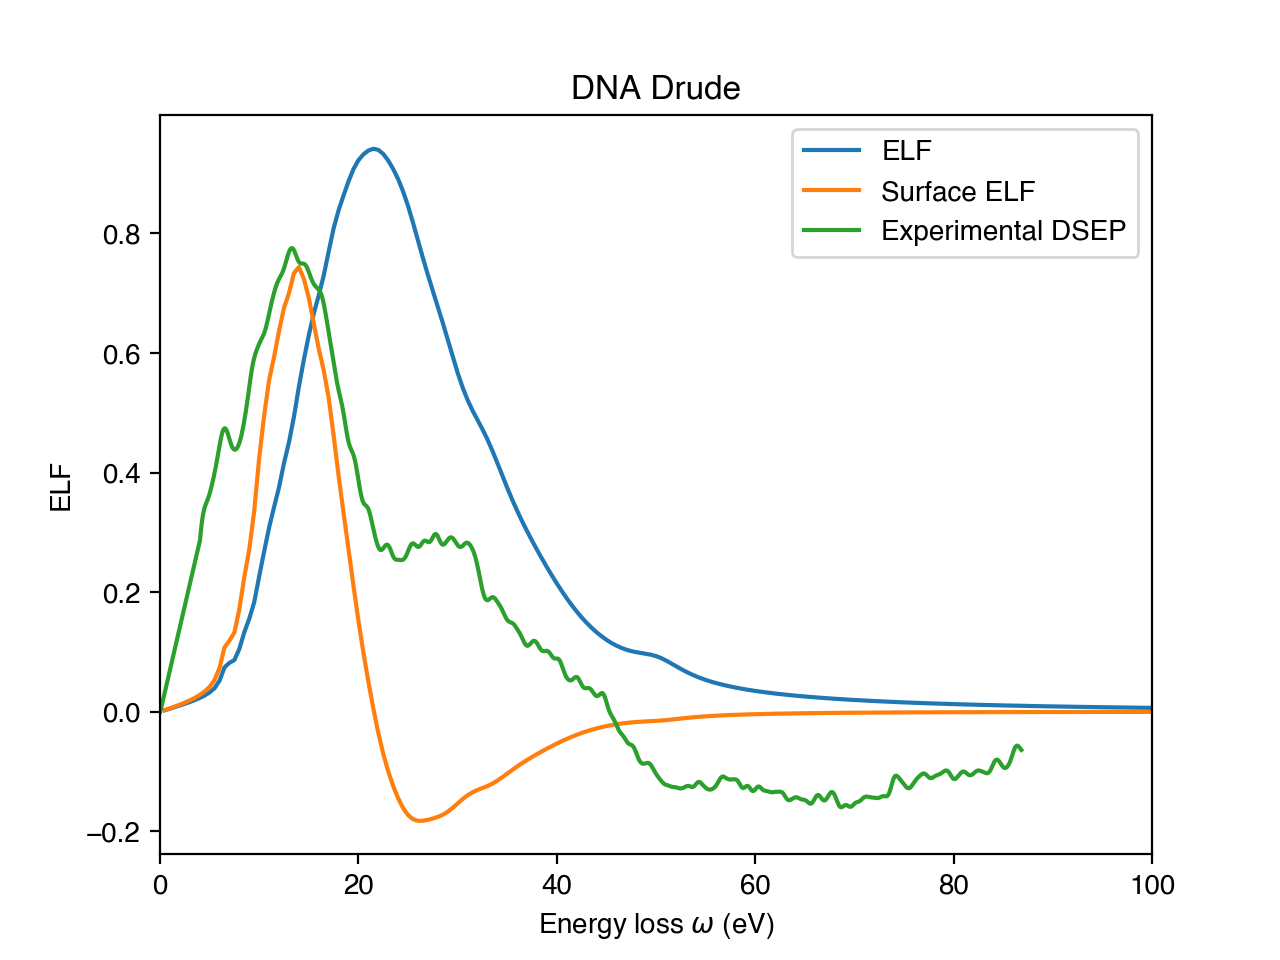

In [34]:
eps = eps_sum(oscParams)

# extending the ELF with the Henke ionisation data to higher energy losses
#=========================================================================
# energy_henke, elf_henke = mopt(oscParams.composition, oscParams.na)
# ind_henke = energy_henke > 100
# ind = oscParams.eloss <= 100
# eloss = np.concatenate((oscParams.eloss[ind],energy_henke[ind_henke]))
# elf = np.concatenate(((-1/eps).imag[ind],elf_henke[ind_henke]))
# plt.plot(eloss,elf)
#=========================================================================

fd = pd.read_csv(f'../MATLAB/dsep/{oscParams.name}_dsep.dat',sep=' ',header=None)
exp_dsep = fd.values

eps_1 = eps.real
eps_2 = eps.imag
den = (eps_1**2 + eps_1 - eps_2**2)**2 + (2*eps_1*eps_2 + eps_2)**2
enu = -eps_2*(2*eps_1 + 1)*((eps_1 - 1)**2 - eps_2**2)
enu += 2*eps_2*(eps_1 - 1)*(eps_1*(eps_1 + 1) - eps_2**2)
surf_elf = enu/den

plt.figure()
# plt.plot(oscParams.eloss,eps.real,label='$\epsilon_1$')
# plt.plot(oscParams.eloss,eps.imag,label='$\epsilon_2$')
plt.plot(oscParams.eloss,(-1/eps).imag,label='ELF')
plt.plot(oscParams.eloss,surf_elf,label='Surface ELF')
# plt.plot(oscParams.eloss,(-1/(eps+1)).imag,label='Surface ELF')
plt.plot(exp_dsep[:,0],exp_dsep[:,1]*20,label='Experimental DSEP')

plt.xlabel('Energy loss $\omega$ (eV)')
plt.ylabel('ELF')
plt.title(f'{oscParams.name} {oscParams.model}')
plt.xlim(0,100)
plt.legend()
plt.show()

plt.savefig(f'{oscParams.name}_{oscParams.model}_surface.png',dpi=600)

<IPython.core.display.Javascript object>


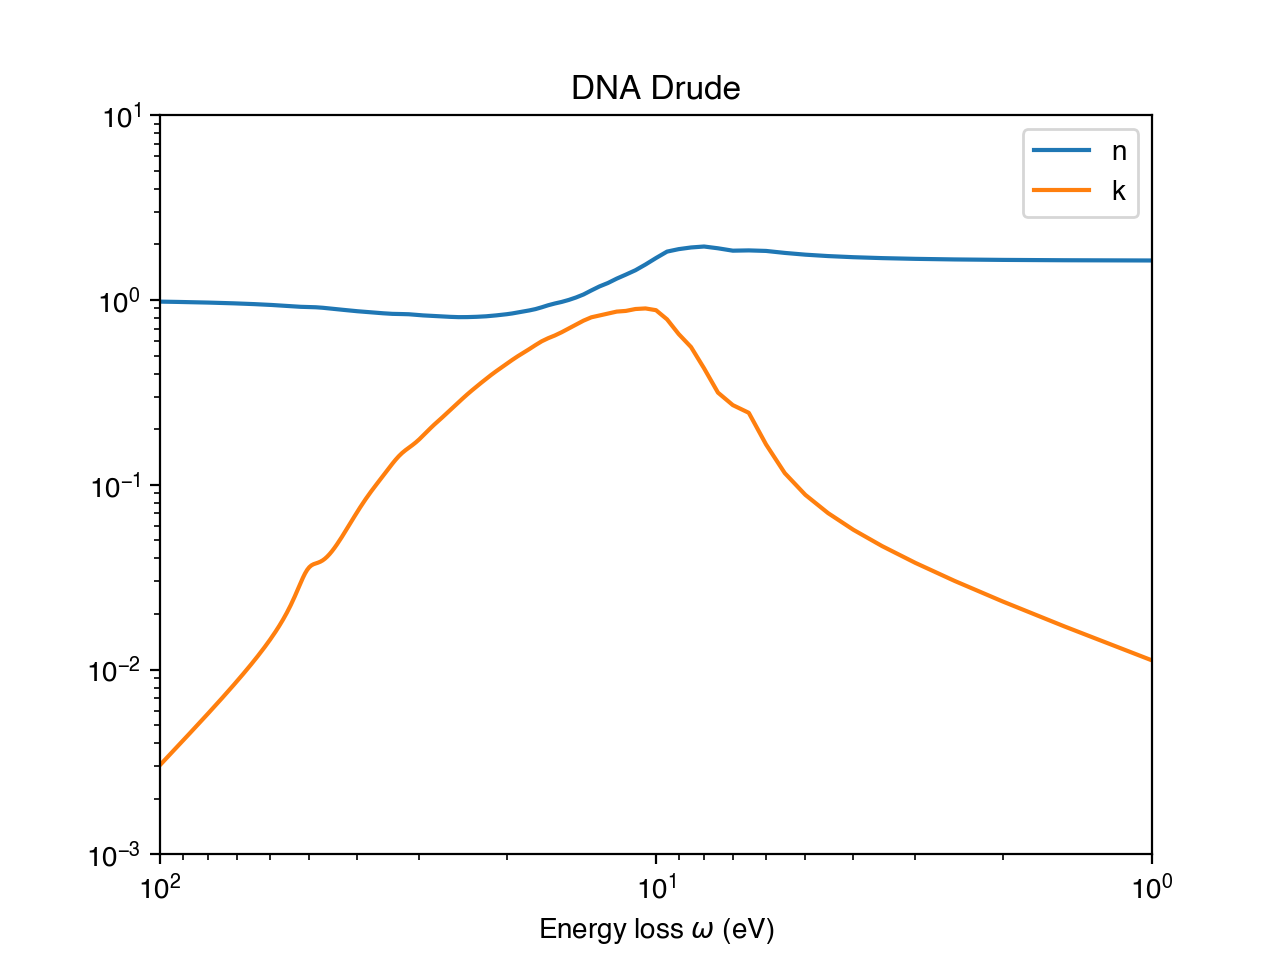

In [35]:
n_complex = np.sqrt(eps)
n = n_complex.real
k = n_complex.imag

plt.figure()
plt.plot(oscParams.eloss,n,label='n')
plt.plot(oscParams.eloss,k,label='k')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Energy loss $\omega$ (eV)')
plt.xlim(100,1)
plt.ylim(0.001,10)
plt.legend()
plt.title(f'{oscParams.name} {oscParams.model}')
plt.show()

In [66]:
d  = dict(E=np.round(oscParams.eloss,2),n=np.round(n,2),k=np.round(k,2),eps1=np.round(eps_1,2), eps2=np.round(eps_2,2), elf=np.round((-1/eps).imag,2))
df = pd.DataFrame.from_dict(d, orient='index').transpose().fillna('')

caption = f'Values of the real $\\epsilon_1$ and imaginary $\\epsilon_2$ parts of the complex dielectric constant and the ELF Im$\\left( -1/\\epsilon \\right)$ of {oscParams.name} derived from the REELS data based on the {oscParams.model} model dielectric function.'
print(df.to_latex(index=False, header=['E','$n$','$k$','$\\epsilon_1$','$\\epsilon_2$','ELF'],escape=False,caption=caption,column_format='cccccc',label=f'tab:{oscParams.name}_opt_data_table'))

with open(f'{oscParams.name}_{oscParams.model}_table_optical_data.tex', 'w') as tf:
     tf.write(df.to_latex(index=False, header=['E','$n$','$k$','$\\epsilon_1$','$\\epsilon_2$','ELF'],escape=False,caption=caption,column_format='cccccc',label=f'tab:{oscParams.name}_opt_data_table'))

\begin{table}
\centering
\caption{Values of the real $\epsilon_1$ and imaginary $\epsilon_2$ parts of the complex dielectric constant and the ELF Im$\left( -1/\epsilon \right)$ of DNA derived from the REELS data based on the Drude model dielectric function.}
\label{tab:DNA_opt_data_table}
\begin{tabular}{cccccc}
\toprule
     E &   $n$ &   $k$ & $\epsilon_1$ & $\epsilon_2$ &   ELF \\
\midrule
   0.5 &  1.63 &  0.01 &         2.67 &         0.02 &  0.00 \\
   1.0 &  1.64 &  0.01 &         2.68 &         0.04 &  0.01 \\
   1.5 &  1.64 &  0.02 &         2.69 &         0.06 &  0.01 \\
   2.0 &  1.65 &  0.02 &         2.72 &         0.08 &  0.01 \\
   2.5 &  1.66 &  0.03 &         2.75 &         0.10 &  0.01 \\
   3.0 &  1.67 &  0.04 &         2.79 &         0.13 &  0.02 \\
   3.5 &  1.69 &  0.05 &         2.84 &         0.16 &  0.02 \\
   4.0 &  1.70 &  0.06 &         2.90 &         0.19 &  0.02 \\
   4.5 &  1.73 &  0.07 &         2.98 &         0.24 &  0.03 \\
   5.0 &  1.76 &  0.09 &    

In [ ]:
d  = dict(E=np.round(oscParams.eloss,2),n=np.round(n,2),k=np.round(k,2),eps1=np.round(eps_1,2), eps2=np.round(eps_2,2), elf=np.round((-1/eps).imag,2))
df = pd.DataFrame.from_dict(d, orient='index').transpose().fillna('')

caption = f'Values of the real $\\epsilon_1$ and imaginary $\\epsilon_2$ parts of the complex dielectric constant and the ELF Im$\\left( -1/\\epsilon \\right)$ of {oscParams.name} derived from the REELS data based on the {oscParams.model} model dielectric function.'
print(df.to_latex(index=False, header=['E','$n$','$k$','$\\epsilon_1$','$\\epsilon_2$','ELF'],escape=False,caption=caption,column_format='cccccc',label=f'tab:{oscParams.name}_opt_data_table'))

*normalised DIIMFP*

<IPython.core.display.Javascript object>


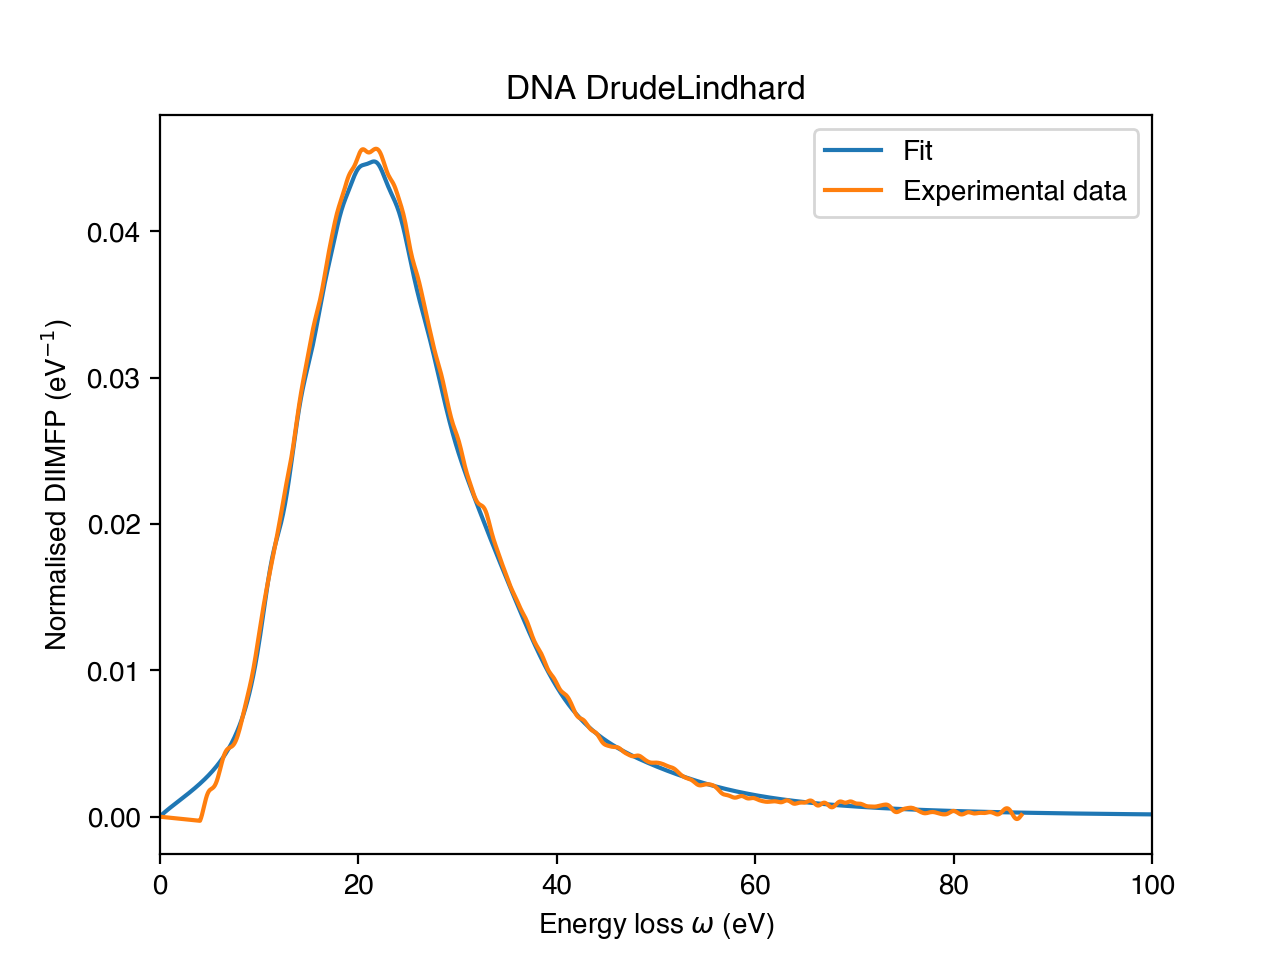

In [76]:
E0 = 1600 
eloss, w = diimfp(oscParams, E0, 11)
w_normalised = w / np.trapz(w, eloss)

fd = pd.read_csv(f'diimfp/{oscParams.name}_diimfp.dat',sep=' ',header=None)
exp_diimfp = fd.values

plt.figure()
plt.plot(eloss,w_normalised,label='Fit')
plt.plot(exp_diimfp[:,0],exp_diimfp[:,1],label='Experimental data')
plt.xlabel('Energy loss $\omega$ (eV)')
plt.ylabel('Normalised DIIMFP (eV$^{-1}$)')
plt.title(f'{oscParams.name} {oscParams.model}')
plt.legend()
plt.xlim(0,100)
plt.show()

*IMFP*

<IPython.core.display.Javascript object>


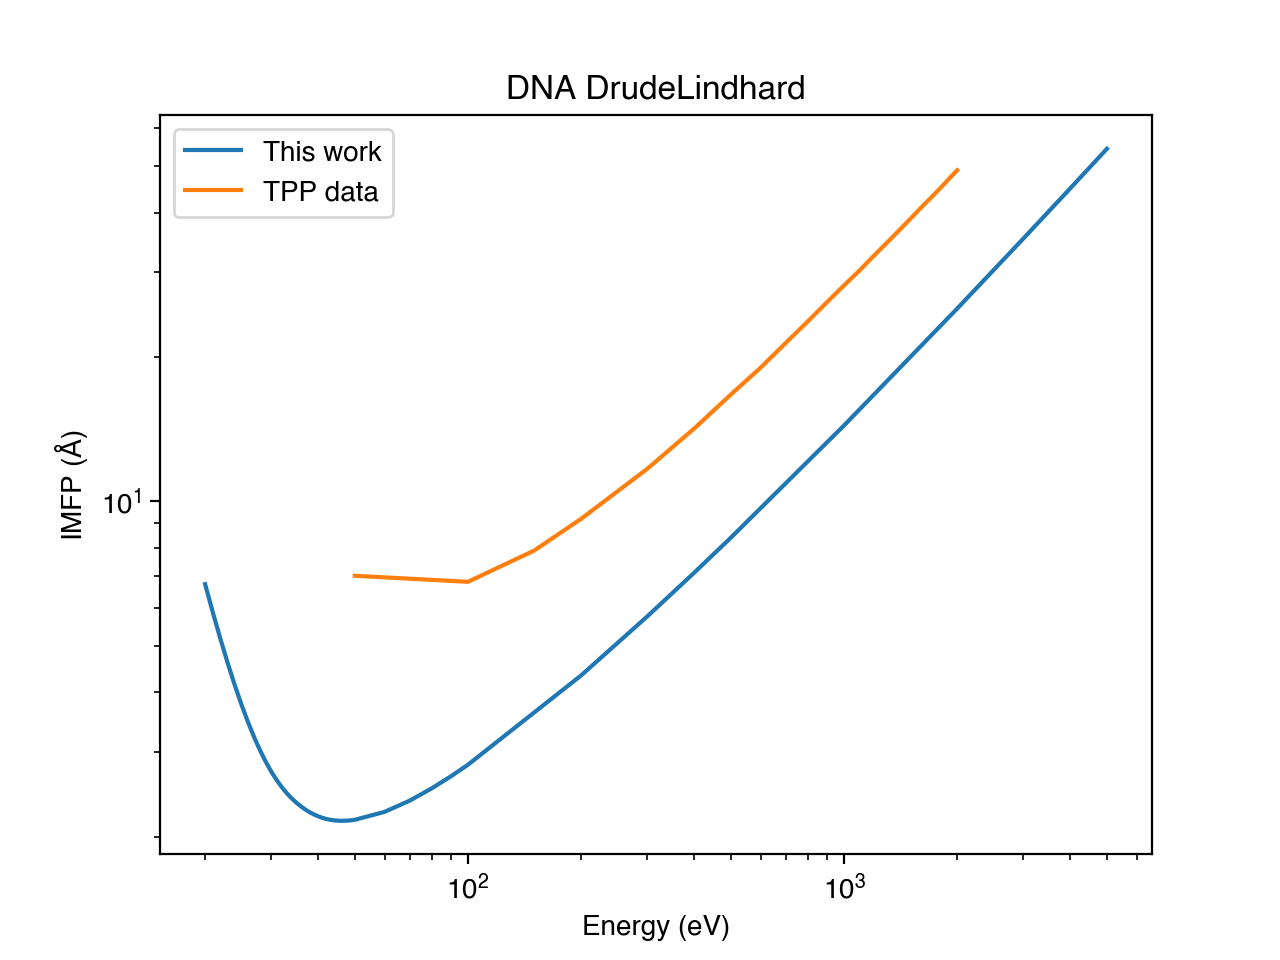

In [77]:
E0 = np.hstack((linspace(20,50),linspace(60,100,10),linspace(200,500,100),linspace(1000,5000,1000)))
lin = imfp(oscParams,E0)

plt.figure()
plt.plot(E0, lin,label='This work')
plt.plot(tpp_data[:,0],tpp_data[:,5],label='TPP data')
plt.xlabel('Energy (eV)')
plt.ylabel('IMFP ($\mathrm{\AA}$)')
plt.yscale('log')
plt.xscale('log')
plt.title(f'{oscParams.name} {oscParams.model}')
plt.legend()
plt.show()

**Irganox**

In [75]:
oscParams = Osc()
oscParams.model = 'Drude'
oscParams.name = 'Irganox'
oscParams.composition = {'element': ['c','o','h'], 'index': [73,12,108]}
oscParams.A = np.array([4.19,16.58,32.18,55.48,35.05,9.03,21.51,25.32,29.22,11.87,34.75,30.35,30.16,30.86,16.16])
oscParams.omega = np.array([6.2,9.6,11.4,13.6,16.2,18.3,19.7,22.0,25.4,30.0,30.6,38.0,46.6,56.7,72.9])
oscParams.gamma = np.array([0.7,2.3,3.3,4.1,4.2,3.2,5.3,6.2,8.0,14.5,11.5,13.7,14.3,16.5,14.0])
oscParams.alpha = 0
# oscParams.eloss = linspace(machine_eps,100,0.1)
oscParams.eloss = linspace(0.5,100,0.5)
oscParams.q = np.array([0])
oscParams.Eg = 5.4
oscParams.vb = 10
oscParams.na = 0.113

In [71]:
oscParams = Osc()
oscParams.model = 'DrudeLindhard'
oscParams.name = 'Irganox'
oscParams.composition = {'element': ['c','o','h'], 'index': [73,12,108]}
oscParams.A = np.array([0.013,0.024,0.022,0.034,0.041,0.027,0.039,0.036,0.029,0.052,0.011,0.027,0.028,0.032,0.034,0.039,0.026,0.009])
oscParams.omega = np.array([6.36,10.4,12.42,14.49,16,17.34,18.96,20.47,21.81,23.44,25.11,26.6,28.72,31.73,35.99,41.09,48.01,57.08])
oscParams.gamma = np.array([0.62,2.75,2.38,2.91,3.33,2.23,2.68,3.01,3.13,3.95,2.79,3.99,5.79,7.61,16.11,32.31,27.78,99.65])
oscParams.alpha = 0
# oscParams.eloss = linspace(machine_eps,100,0.1)
oscParams.eloss = linspace(0.5,100,0.5)
oscParams.q = np.array([0])
oscParams.Eg = 5.4
oscParams.vb = 10
oscParams.na = 0.113

*Dielectric function*

<IPython.core.display.Javascript object>


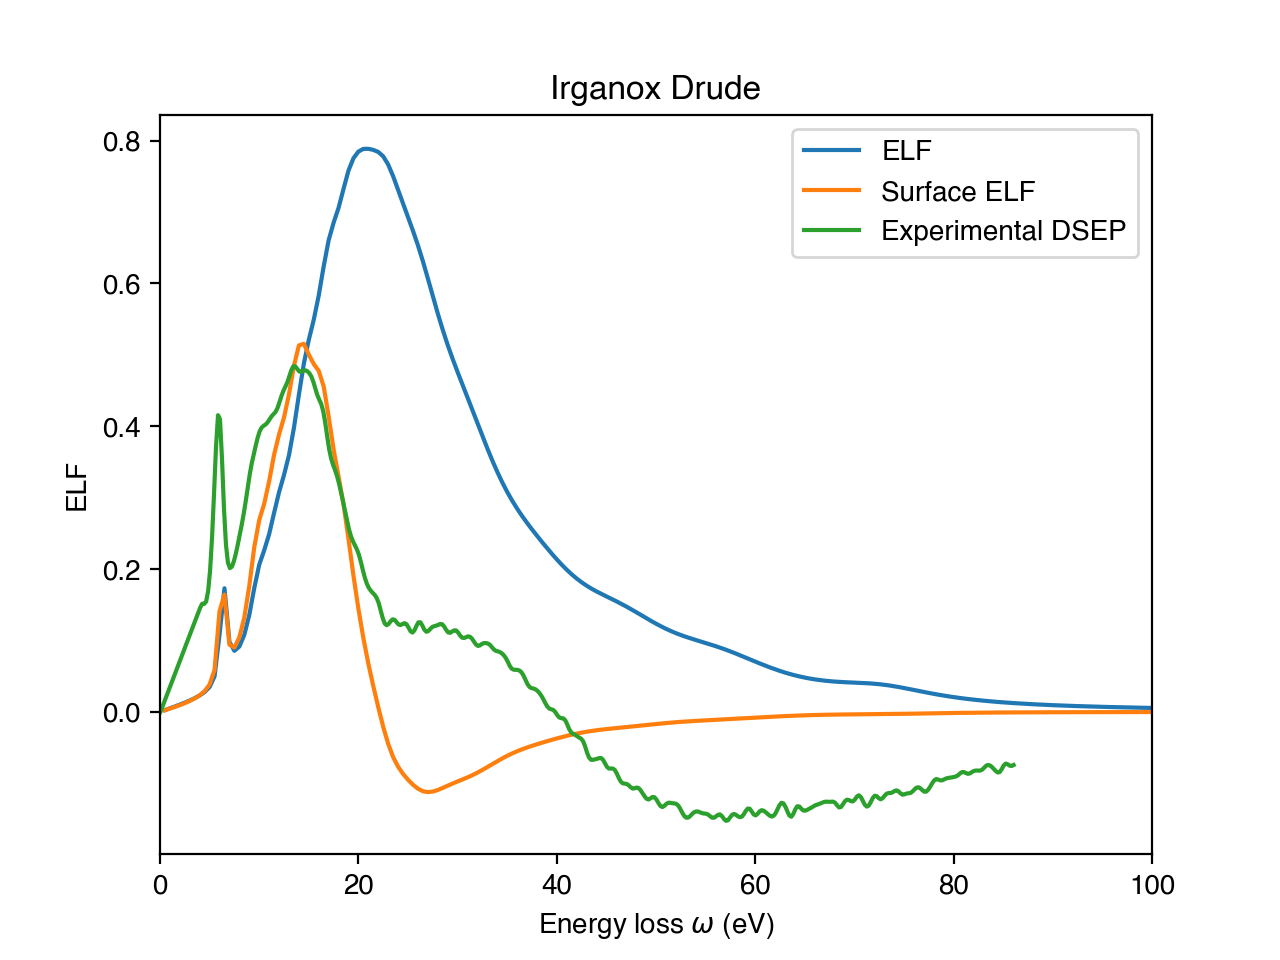

In [76]:
eps = eps_sum(oscParams)

# extending the ELF with the Henke ionisation data to higher energy losses
#=========================================================================
# energy_henke, elf_henke = mopt(oscParams.composition, oscParams.na)
# ind_henke = energy_henke > 100
# ind = oscParams.eloss <= 100
# eloss = np.concatenate((oscParams.eloss[ind],energy_henke[ind_henke]))
# elf = np.concatenate(((-1/eps).imag[ind],elf_henke[ind_henke]))
# plt.plot(eloss,elf)
#=========================================================================

fd = pd.read_csv(f'../MATLAB/dsep/{oscParams.name}_dsep.dat',sep=' ',header=None)
exp_dsep = fd.values

eps_1 = eps.real
eps_2 = eps.imag
den = (eps_1**2 + eps_1 - eps_2**2)**2 + (2*eps_1*eps_2 + eps_2)**2
enu = -eps_2*(2*eps_1 + 1)*((eps_1 - 1)**2 - eps_2**2)
enu += 2*eps_2*(eps_1 - 1)*(eps_1*(eps_1 + 1) - eps_2**2)
surf_elf = enu/den

plt.figure()
# plt.plot(oscParams.eloss,eps.real,label='$\epsilon_1$')
# plt.plot(oscParams.eloss,eps.imag,label='$\epsilon_2$')
plt.plot(oscParams.eloss,(-1/eps).imag,label='ELF')
plt.plot(oscParams.eloss,surf_elf,label='Surface ELF')
plt.plot(exp_dsep[:,0],exp_dsep[:,1]*10,label='Experimental DSEP')

plt.xlabel('Energy loss $\omega$ (eV)')
plt.ylabel('ELF')
plt.title(f'{oscParams.name} {oscParams.model}')
plt.xlim(0,100)
plt.legend()
plt.show()

plt.savefig(f'{oscParams.name}_{oscParams.model}_surface.png',dpi=600)

<IPython.core.display.Javascript object>


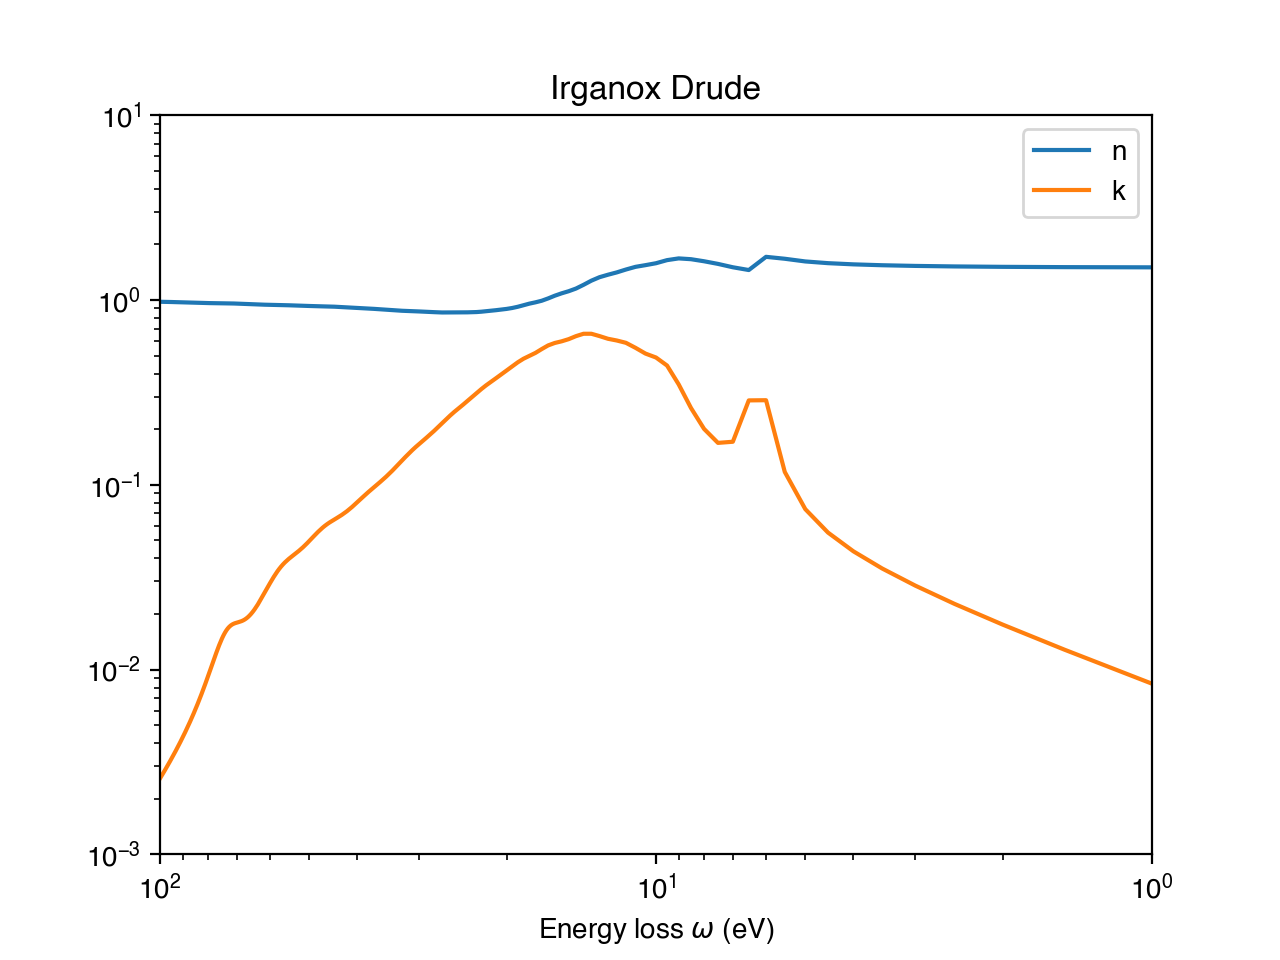

In [77]:
n_complex = np.sqrt(eps)
n = n_complex.real
k = n_complex.imag

plt.figure()
plt.plot(oscParams.eloss,n,label='n')
plt.plot(oscParams.eloss,k,label='k')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Energy loss $\omega$ (eV)')
plt.xlim(100,1)
plt.ylim(0.001,10)
plt.legend()
plt.title(f'{oscParams.name} {oscParams.model}')
plt.show()

In [78]:
d  = dict(E=np.round(oscParams.eloss,2),n=np.round(n,2),k=np.round(k,2),eps1=np.round(eps_1,2), eps2=np.round(eps_2,2), elf=np.round((-1/eps).imag,2))
df = pd.DataFrame.from_dict(d, orient='index').transpose().fillna('')

caption = f'Values of the real $\\epsilon_1$ and imaginary $\\epsilon_2$ parts of the complex dielectric constant and the ELF Im$\\left( -1/\\epsilon \\right)$ of {oscParams.name} derived from the REELS data based on the {oscParams.model} model dielectric function.'
print(df.to_latex(index=False, header=['E','$n$','$k$','$\\epsilon_1$','$\\epsilon_2$','ELF'],escape=False,caption=caption,column_format='cccccc',label=f'tab:{oscParams.name}_opt_data_table'))

with open(f'{oscParams.name}_{oscParams.model}_table_optical_data.tex', 'w') as tf:
     tf.write(df.to_latex(index=False, header=['E','$n$','$k$','$\\epsilon_1$','$\\epsilon_2$','ELF'],escape=False,caption=caption,column_format='cccccc',label=f'tab:{oscParams.name}_opt_data_table'))

\begin{table}
\centering
\caption{Values of the real $\epsilon_1$ and imaginary $\epsilon_2$ parts of the complex dielectric constant and the ELF Im$\left( -1/\epsilon \right)$ of Irganox derived from the REELS data based on the Drude model dielectric function.}
\label{tab:Irganox_opt_data_table}
\begin{tabular}{cccccc}
\toprule
     E &   $n$ &   $k$ & $\epsilon_1$ & $\epsilon_2$ &   ELF \\
\midrule
   0.5 &  1.50 &  0.00 &         2.25 &         0.01 &  0.00 \\
   1.0 &  1.50 &  0.01 &         2.26 &         0.03 &  0.00 \\
   1.5 &  1.51 &  0.01 &         2.27 &         0.04 &  0.01 \\
   2.0 &  1.51 &  0.02 &         2.28 &         0.05 &  0.01 \\
   2.5 &  1.52 &  0.02 &         2.31 &         0.07 &  0.01 \\
   3.0 &  1.53 &  0.03 &         2.34 &         0.09 &  0.02 \\
   3.5 &  1.54 &  0.04 &         2.38 &         0.11 &  0.02 \\
   4.0 &  1.56 &  0.04 &         2.43 &         0.14 &  0.02 \\
   4.5 &  1.58 &  0.06 &         2.50 &         0.17 &  0.03 \\
   5.0 &  1.62 &  0.

*normalised DIIMFP*

<IPython.core.display.Javascript object>


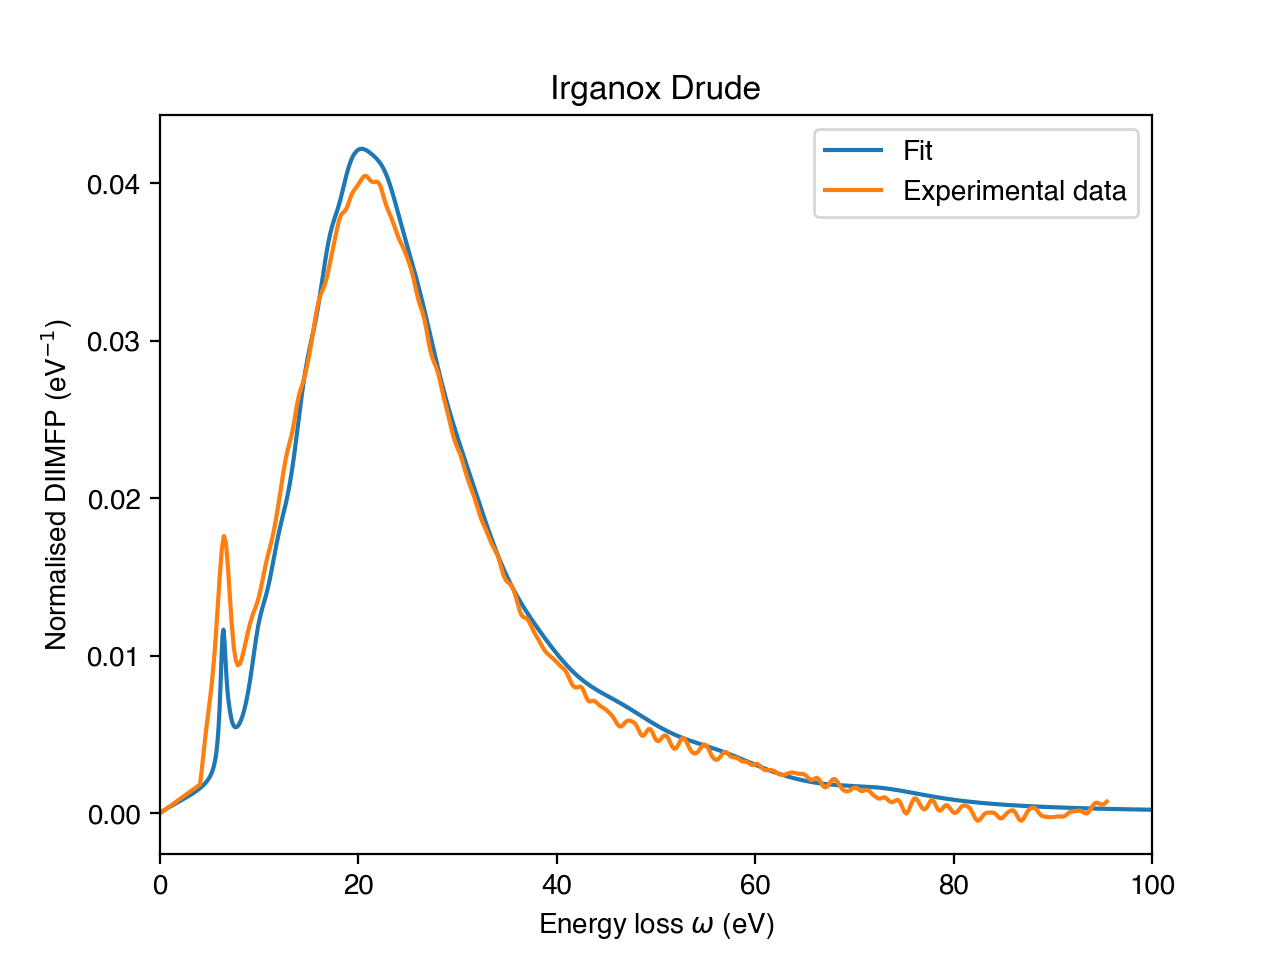

In [107]:
E0 = 1600 
eloss, w = diimfp(oscParams, E0, 11)
w_normalised = w / np.trapz(w, eloss)

fd = pd.read_csv(f'diimfp/{oscParams.name}_diimfp.dat',sep=' ',header=None)
exp_diimfp = fd.values

plt.figure()
plt.plot(eloss,w_normalised,label='Fit')
plt.plot(exp_diimfp[:,0],exp_diimfp[:,1],label='Experimental data')
plt.xlabel('Energy loss $\omega$ (eV)')
plt.ylabel('Normalised DIIMFP (eV$^{-1}$)')
plt.title(f'{oscParams.name} {oscParams.model}')
plt.legend()
plt.xlim(0,100)
plt.show()

*IMFP*

<IPython.core.display.Javascript object>


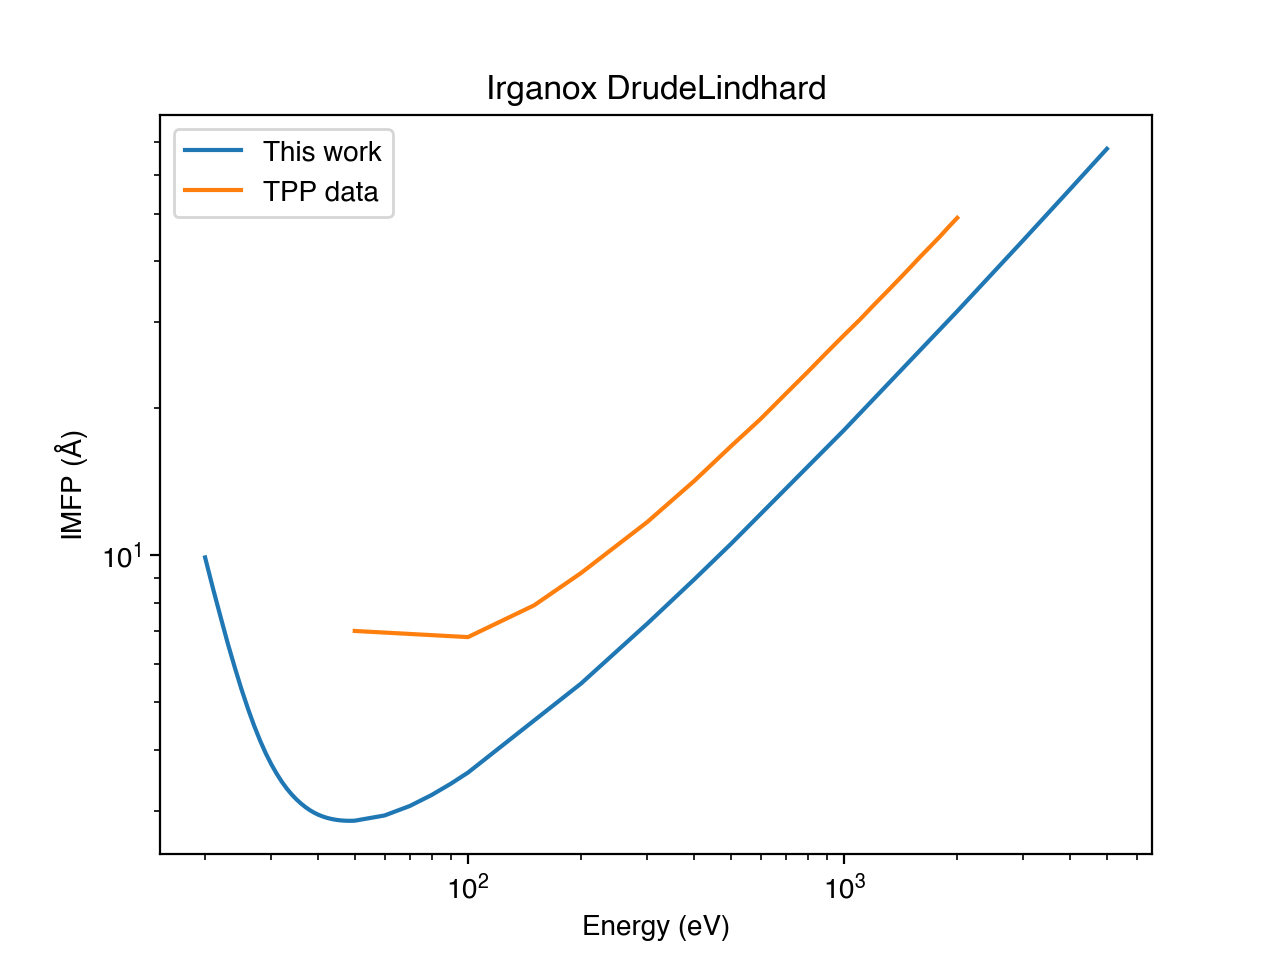

In [100]:
E0 = np.hstack((linspace(20,50),linspace(60,100,10),linspace(200,500,100),linspace(1000,5000,1000)))
lin = imfp(oscParams,E0)

plt.figure()
plt.plot(E0, lin,label='This work')
plt.xlabel('Energy (eV)')
plt.ylabel('IMFP ($\mathrm{\AA}$)')
plt.yscale('log')
plt.xscale('log')
plt.title(f'{oscParams.name} {oscParams.model}')
plt.legend()
plt.show()

**Kapton**

In [79]:
oscParams = Osc()
oscParams.model = 'Drude'
oscParams.name = 'Kapton'
oscParams.composition = {'element': ['c','n','o','h'], 'index': [22,2,5,10]}
oscParams.A = np.array([30.3300, 9.3000, 23.8700, 42.6400, 42.3600, 35.4100, 71.0900, 38.1300, 31.0700, 32.3500, 30.4500, 27.7000, 10.89])
oscParams.omega = np.array([5.5000, 8.7000, 10.1000, 11.8000, 14.2000, 16.7000, 20.1000, 25.3000, 31.4000, 38.2000, 47.5000, 57.0, 66.1000])
oscParams.gamma = np.array([1.9000, 1.5000, 2.5000, 3.5000, 5.0, 6.3000, 10.1000, 10.2000, 11.6000, 15.2000, 17.7000, 14.1000, 8.7000])
oscParams.alpha = 0
# oscParams.eloss = np.linspace(0,100,1000)
oscParams.eloss = linspace(0.5,100,0.5)
oscParams.q = np.array([0])
oscParams.Eg = 4.2
oscParams.vb = 10
oscParams.na = 0.087

In [46]:
oscParams = Osc()
oscParams.model = 'DrudeLindhard'
oscParams.name = 'Kapton'
oscParams.composition = {'element': ['c','n','o','h'], 'index': [22,2,5,10]}
oscParams.A = np.array([0.0589, 0.0177, 0.0230, 0.0518, 0.0256, 0.0444, 0.0654, 0.0580, 0.0299, 0.0346, 0.0460, 0.0311, 0.0572, 0.0403, 0.0246, 0.0042, 0.0066, 0.0271 ,0.0381])
oscParams.omega = np.array([6.4308 ,   9.3545,   10.4160,   12.8358,   14.5493,   17.9100 ,  31.0085,   16.2088,   25.6976,   19.4088,   21.1176,   22.6716 ,  23.8908,   27.0637 ,  33.4172 ,  28.5393, 43.4855  , 37.4778  , 51.1779])
oscParams.gamma = np.array([1.6541, 5.3195, 3.0195, 3.5204, 2.9094, 3.3016, 10.1210, 3.7165, 5.9298, 3.0002, 3.6067, 4.7132, 5.9191, 6.8097, 16.7415, 7.4865, 61.2568, 12.6167, 26.2328])
oscParams.alpha = 0
oscParams.eloss = np.linspace(0,100,1000)
oscParams.q = np.array([0])
oscParams.Eg = 4.2
oscParams.vb = 10
oscParams.na = 0.087

*Dielectric function*

<IPython.core.display.Javascript object>


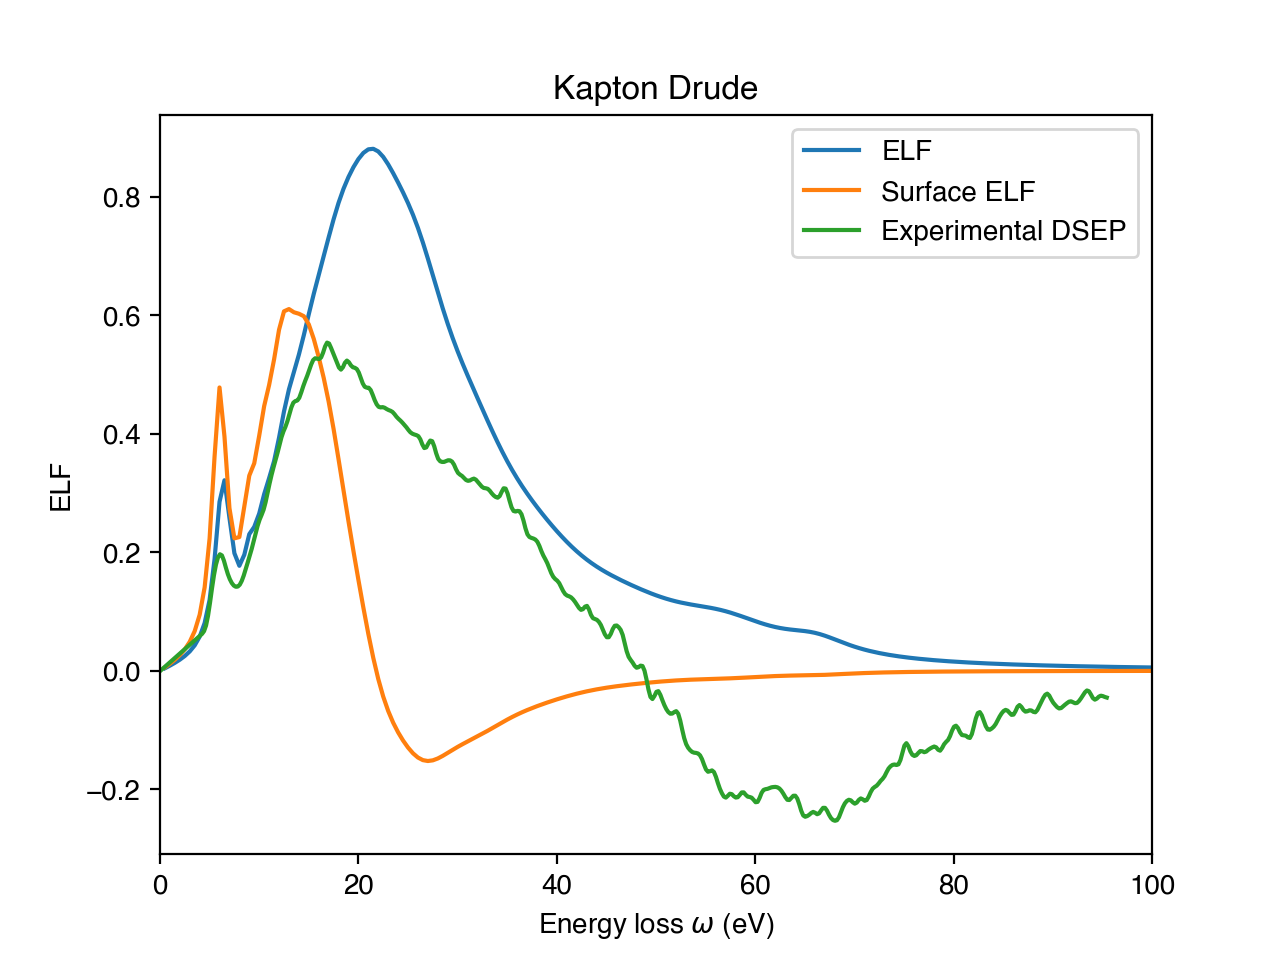

In [80]:
eps = eps_sum(oscParams)

eps_1 = eps.real
eps_2 = eps.imag
den = (eps_1**2 + eps_1 - eps_2**2)**2 + (2*eps_1*eps_2 + eps_2)**2
enu = -eps_2*(2*eps_1 + 1)*((eps_1 - 1)**2 - eps_2**2)
enu += 2*eps_2*(eps_1 - 1)*(eps_1*(eps_1 + 1) - eps_2**2)
surf_elf = enu/den

# extending the ELF with the Henke ionisation data to higher energy losses
#=========================================================================
# energy_henke, elf_henke = mopt(oscParams.composition, oscParams.na)
# ind_henke = energy_henke > 100
# ind = oscParams.eloss <= 100
# eloss = np.concatenate((oscParams.eloss[ind],energy_henke[ind_henke]))
# elf = np.concatenate(((-1/eps).imag[ind],elf_henke[ind_henke]))
# plt.plot(eloss,elf)
#=========================================================================

fd = pd.read_csv(f'../MATLAB/dsep/{oscParams.name}_dsep.dat',sep=' ',header=None)
exp_dsep = fd.values

plt.figure()
# plt.plot(oscParams.eloss,eps.real,label='$\epsilon_1$')
# plt.plot(oscParams.eloss,eps.imag,label='$\epsilon_2$')
plt.plot(oscParams.eloss,(-1/eps).imag,label='ELF')
plt.plot(oscParams.eloss,surf_elf,label='Surface ELF')
plt.plot(exp_dsep[:,0],exp_dsep[:,1]*18,label='Experimental DSEP')

plt.xlabel('Energy loss $\omega$ (eV)')
plt.ylabel('ELF')
plt.title(f'{oscParams.name} {oscParams.model}')
plt.xlim(0,100)
plt.legend()
plt.show()

plt.savefig(f'{oscParams.name}_{oscParams.model}_surface.png',dpi=600)

<IPython.core.display.Javascript object>


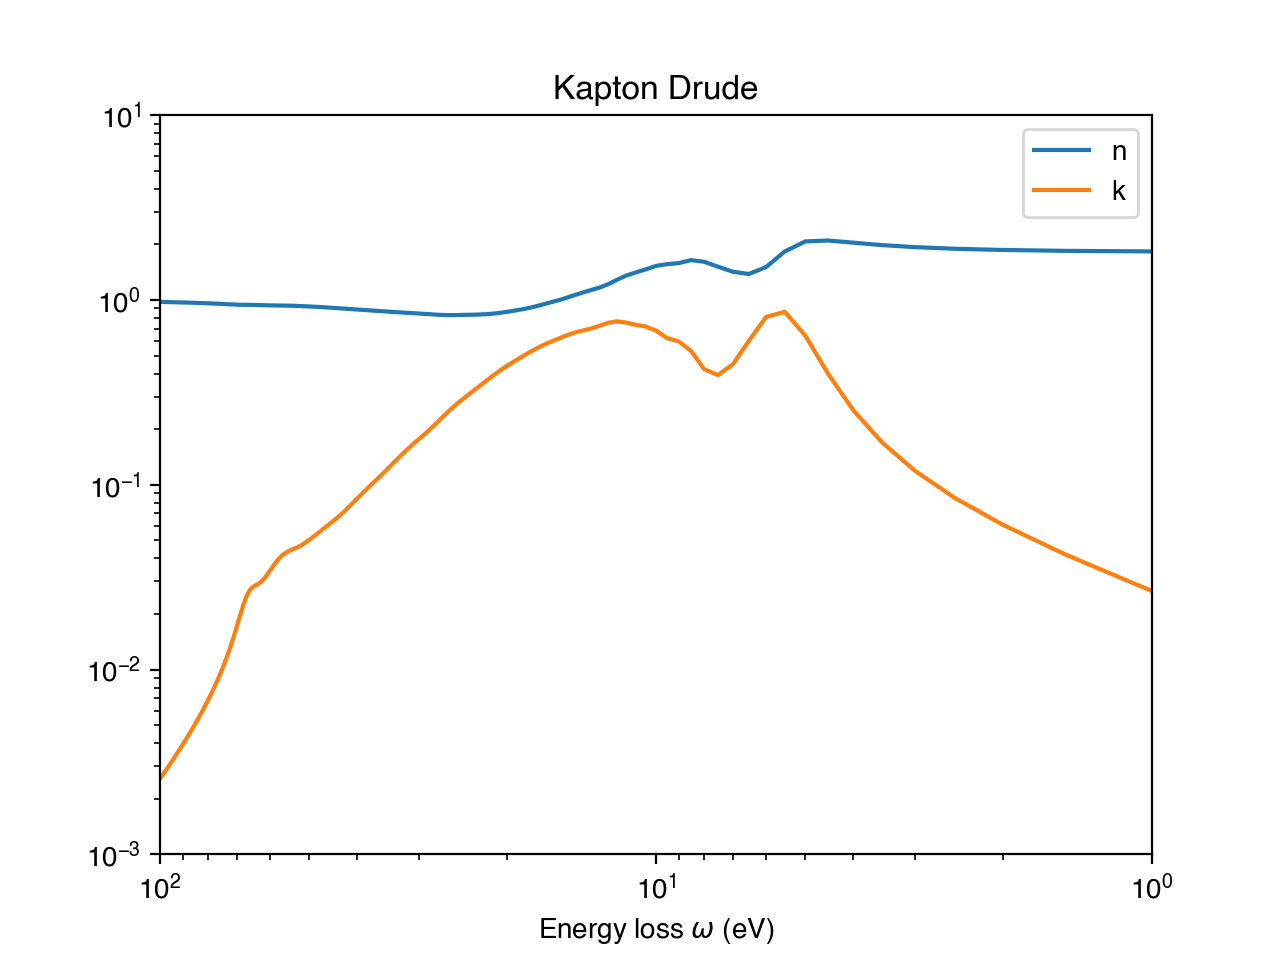

In [81]:
n_complex = np.sqrt(eps)
n = n_complex.real
k = n_complex.imag

plt.figure()
plt.plot(oscParams.eloss,n,label='n')
plt.plot(oscParams.eloss,k,label='k')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Energy loss $\omega$ (eV)')
plt.xlim(100,1)
plt.ylim(0.001,10)
plt.legend()
plt.title(f'{oscParams.name} {oscParams.model}')
plt.show()

In [82]:
d  = dict(E=np.round(oscParams.eloss,2),n=np.round(n,2),k=np.round(k,2),eps1=np.round(eps_1,2), eps2=np.round(eps_2,2), elf=np.round((-1/eps).imag,2))
df = pd.DataFrame.from_dict(d, orient='index').transpose().fillna('')

caption = f'Values of the real $\\epsilon_1$ and imaginary $\\epsilon_2$ parts of the complex dielectric constant and the ELF Im$\\left( -1/\\epsilon \\right)$ of {oscParams.name} derived from the REELS data based on the {oscParams.model} model dielectric function.'
print(df.to_latex(index=False, header=['E','$n$','$k$','$\\epsilon_1$','$\\epsilon_2$','ELF'],escape=False,caption=caption,column_format='cccccc',label=f'tab:{oscParams.name}_opt_data_table'))

with open(f'{oscParams.name}_{oscParams.model}_table_optical_data.tex', 'w') as tf:
     tf.write(df.to_latex(index=False, header=['E','$n$','$k$','$\\epsilon_1$','$\\epsilon_2$','ELF'],escape=False,caption=caption,column_format='cccccc',label=f'tab:{oscParams.name}_opt_data_table'))

\begin{table}
\centering
\caption{Values of the real $\epsilon_1$ and imaginary $\epsilon_2$ parts of the complex dielectric constant and the ELF Im$\left( -1/\epsilon \right)$ of Kapton derived from the REELS data based on the Drude model dielectric function.}
\label{tab:Kapton_opt_data_table}
\begin{tabular}{cccccc}
\toprule
     E &   $n$ &   $k$ & $\epsilon_1$ & $\epsilon_2$ &   ELF \\
\midrule
   0.5 &  1.82 &  0.01 &         3.33 &         0.05 &  0.00 \\
   1.0 &  1.83 &  0.03 &         3.35 &         0.10 &  0.01 \\
   1.5 &  1.85 &  0.04 &         3.40 &         0.16 &  0.01 \\
   2.0 &  1.87 &  0.06 &         3.48 &         0.23 &  0.02 \\
   2.5 &  1.89 &  0.09 &         3.58 &         0.32 &  0.02 \\
   3.0 &  1.93 &  0.12 &         3.72 &         0.46 &  0.03 \\
   3.5 &  1.98 &  0.17 &         3.90 &         0.67 &  0.04 \\
   4.0 &  2.04 &  0.25 &         4.11 &         1.03 &  0.06 \\
   4.5 &  2.10 &  0.40 &         4.24 &         1.68 &  0.08 \\
   5.0 &  2.08 &  0.64

*normalised DIIMFP*

<IPython.core.display.Javascript object>


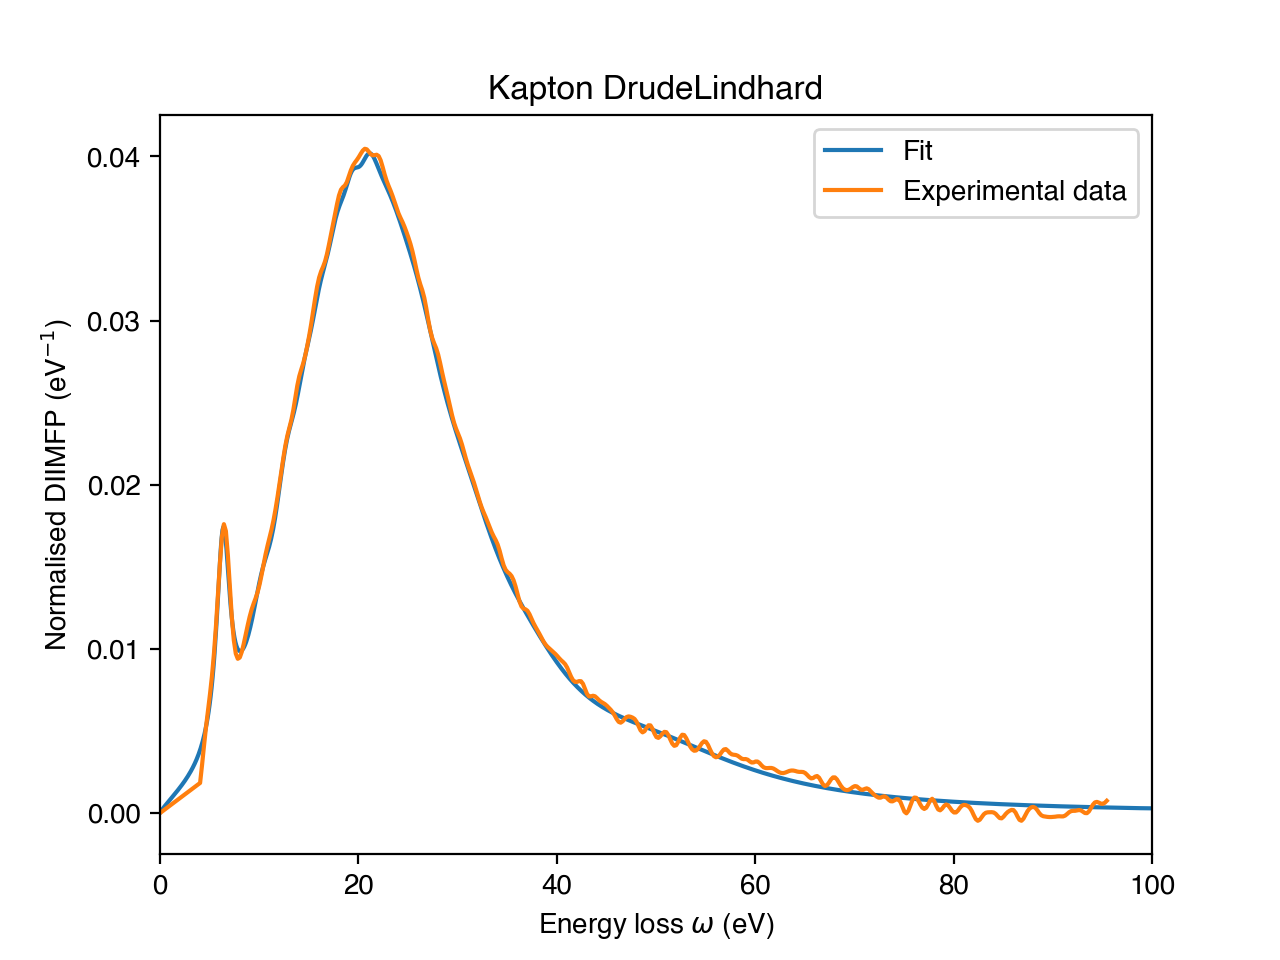

In [57]:
E0 = 1600 
eloss, w = diimfp(oscParams, E0, 11)
w_normalised = w / np.trapz(w, eloss)

fd = pd.read_csv(f'diimfp/{oscParams.name}_diimfp.dat',sep=' ',header=None)
exp_diimfp = fd.values

plt.figure()
plt.plot(eloss,w_normalised,label='Fit')
plt.plot(exp_diimfp[:,0],exp_diimfp[:,1],label='Experimental data')
plt.xlabel('Energy loss $\omega$ (eV)')
plt.ylabel('Normalised DIIMFP (eV$^{-1}$)')
plt.title(f'{oscParams.name} {oscParams.model}')
plt.legend()
plt.xlim(0,100)
plt.show()

*IMFP*

<IPython.core.display.Javascript object>


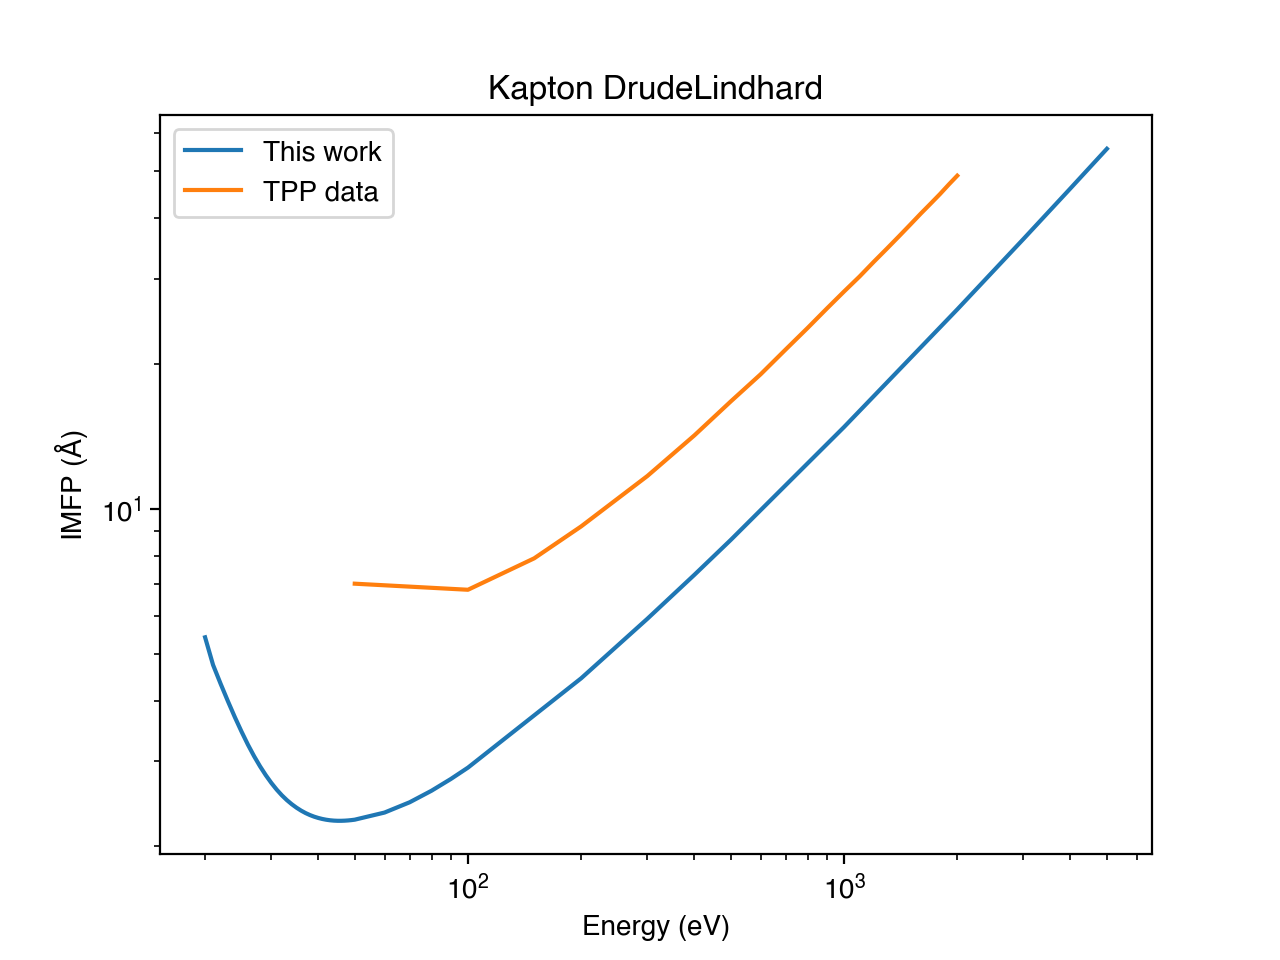

In [73]:
E0 = np.hstack((linspace(20,50),linspace(60,100,10),linspace(200,500,100),linspace(1000,5000,1000)))
lin = imfp(oscParams,E0)

plt.figure()
plt.plot(E0, lin,label='This work')
plt.plot(tpp_data[:,0],tpp_data[:,8],label='TPP data')
plt.xlabel('Energy (eV)')
plt.ylabel('IMFP ($\mathrm{\AA}$)')
plt.yscale('log')
plt.xscale('log')
plt.title(f'{oscParams.name} {oscParams.model}')
plt.legend()
plt.show()

**PMMA**

In [83]:
oscParams = Osc()
oscParams.model = 'Drude'
oscParams.name = 'PMMA'
oscParams.composition = {'element': ['c','o','h'], 'index': [5,2,8]}
oscParams.A = np.array([1196.37, 2515.98, 2213.80, 2669.71, 2772.29, 2955.37, 2761.49, 2344.97, 3924.08, 2837.09, 2849.39, 2244.36, 1676.07, 1990.05, 4195.62])*0.01
oscParams.gamma = np.array([2.1, 2.2, 2.1, 2.6, 3.1, 4.0, 5.1, 6.1, 9.3, 11.6, 15.8, 16.6, 21.2, 22.3, 41.6])
oscParams.omega = np.array([9.3, 10.5, 11.9, 13.2, 14.6, 16.5, 18.7, 21.2, 24.2, 28.5, 32.0, 36.3, 44.6, 48.4 ,62.0])
oscParams.alpha = 0
# oscParams.eloss = np.linspace(0,100,1000)
oscParams.eloss = linspace(0.5,100,0.5)
oscParams.q = np.array([0])
oscParams.Eg = 6.7
oscParams.vb = 10
oscParams.na = 0.10646

In [52]:
oscParams = Osc()
oscParams.model = 'DrudeLindhard'
oscParams.name = 'PMMA'
oscParams.composition = {'element': ['c','o','h'], 'index': [5,2,8]}
oscParams.A = np.array([0.0554,    0.0254,    0.0419,    0.0749,    0.0774 ,   0.0770 ,   0.0865  ,  0.0533 ,   0.0517])
oscParams.gamma = np.array([3.4057 ,   2.6683 ,   3.1839  ,  4.5936 ,   5.6249  ,  7.8471 ,  13.8955  ,  3.5461,   40.6549])
oscParams.omega = np.array([16.1034,   11.4187,   13.8703 ,  20.6540  , 23.4906 ,  27.0763 ,  32.4494 , 18.2478,   44.8547])
oscParams.alpha = 0
oscParams.eloss = np.linspace(0,100,1000)
oscParams.q = np.array([0])
oscParams.Eg = 6.7
oscParams.vb = 10
oscParams.na = 0.10646

*Dielectric function*

<IPython.core.display.Javascript object>


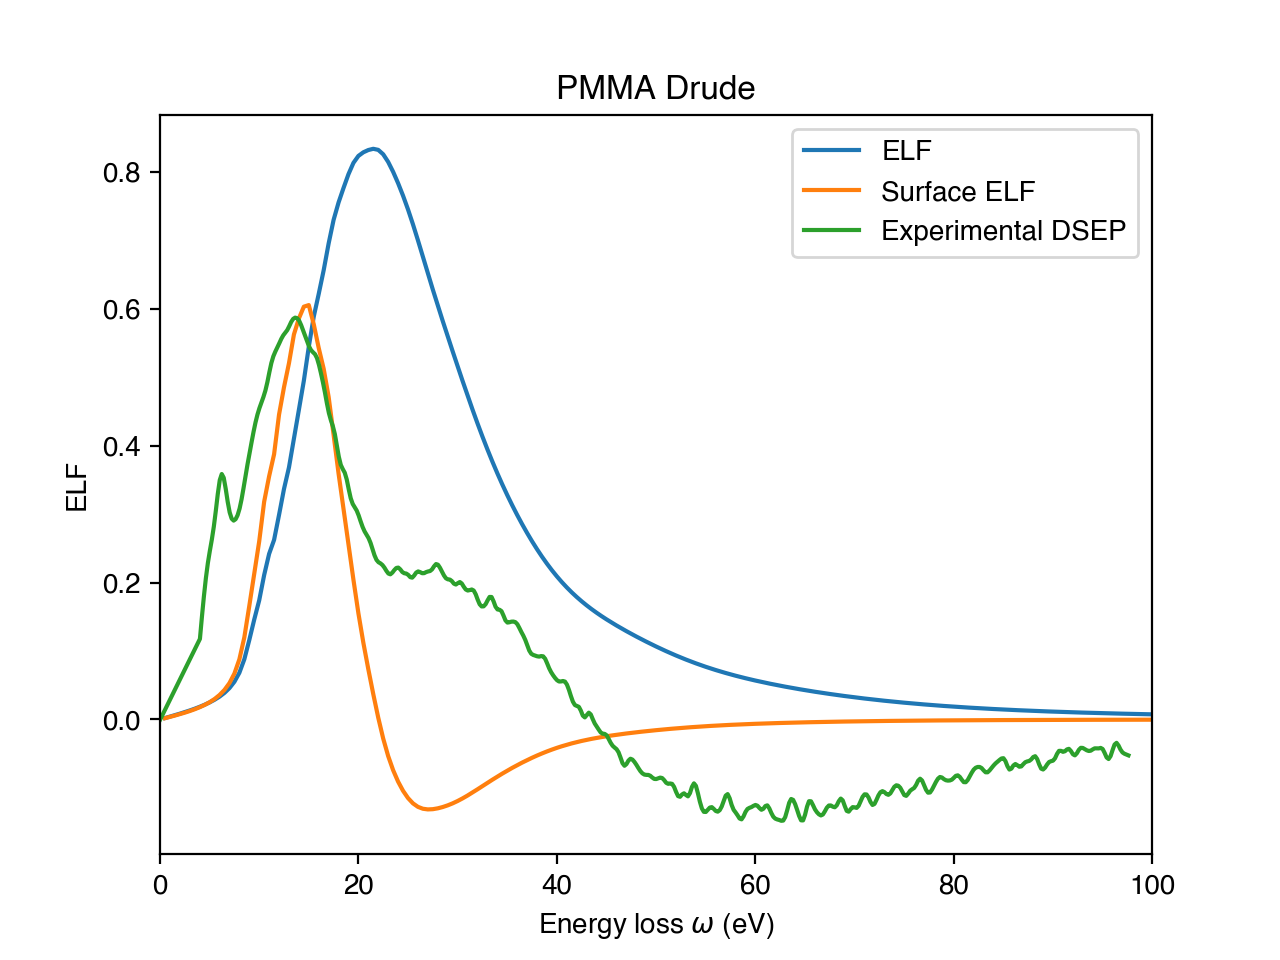

In [84]:
eps = eps_sum(oscParams)

eps_1 = eps.real
eps_2 = eps.imag
den = (eps_1**2 + eps_1 - eps_2**2)**2 + (2*eps_1*eps_2 + eps_2)**2
enu = -eps_2*(2*eps_1 + 1)*((eps_1 - 1)**2 - eps_2**2)
enu += 2*eps_2*(eps_1 - 1)*(eps_1*(eps_1 + 1) - eps_2**2)
surf_elf = enu/den

# extending the ELF with the Henke ionisation data to higher energy losses
#=========================================================================
# energy_henke, elf_henke = mopt(oscParams.composition, oscParams.na)
# ind_henke = energy_henke > 100
# ind = oscParams.eloss <= 100
# eloss = np.concatenate((oscParams.eloss[ind],energy_henke[ind_henke]))
# elf = np.concatenate(((-1/eps).imag[ind],elf_henke[ind_henke]))
# plt.plot(eloss,elf)
#=========================================================================

fd = pd.read_csv(f'../MATLAB/dsep/{oscParams.name}_dsep.dat',sep=' ',header=None)
exp_dsep = fd.values

plt.figure()
# plt.plot(oscParams.eloss,eps.real,label='$\epsilon_1$')
# plt.plot(oscParams.eloss,eps.imag,label='$\epsilon_2$')
plt.plot(oscParams.eloss,(-1/eps).imag,label='ELF')
plt.plot(oscParams.eloss,surf_elf,label='Surface ELF')
plt.plot(exp_dsep[:,0],exp_dsep[:,1]*13,label='Experimental DSEP')

plt.xlabel('Energy loss $\omega$ (eV)')
plt.ylabel('ELF')
plt.title(f'{oscParams.name} {oscParams.model}')
plt.xlim(0,100)
plt.legend()
plt.show()

plt.savefig(f'{oscParams.name}_{oscParams.model}_surface.png',dpi=600)

# to save figure
# plt.savefig(f'epsilon_{oscParams.name}.png',dpi=600,bbox_inches='tight')

# to save data to csv
# np.savetxt(f'epsilon_{oscParams.name}.csv', np.transpose([oscParams.eloss,eps.real,eps.imag,(-1/eps).imag]), header="energy(eV) epsilon1 epsilon2 elf", delimiter=" ")

<IPython.core.display.Javascript object>


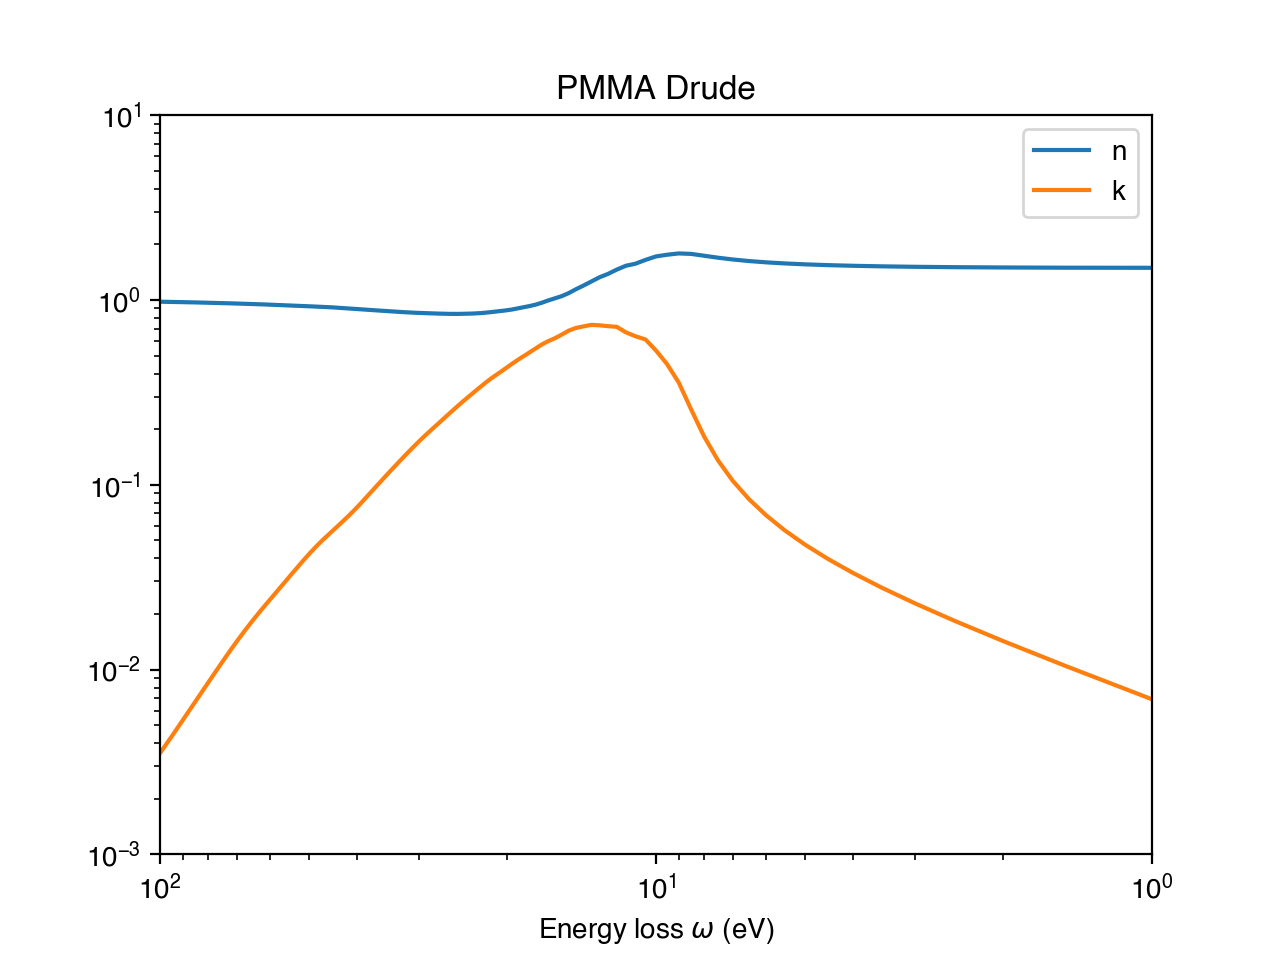

In [85]:
n_complex = np.sqrt(eps)
n = n_complex.real
k = n_complex.imag

plt.figure()
plt.plot(oscParams.eloss,n,label='n')
plt.plot(oscParams.eloss,k,label='k')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Energy loss $\omega$ (eV)')
plt.xlim(100,1)
plt.ylim(0.001,10)
plt.legend()
plt.title(f'{oscParams.name} {oscParams.model}')
plt.show()

In [86]:
d  = dict(E=np.round(oscParams.eloss,2),n=np.round(n,2),k=np.round(k,2),eps1=np.round(eps_1,2), eps2=np.round(eps_2,2), elf=np.round((-1/eps).imag,2))
df = pd.DataFrame.from_dict(d, orient='index').transpose().fillna('')

caption = f'Values of the real $\\epsilon_1$ and imaginary $\\epsilon_2$ parts of the complex dielectric constant and the ELF Im$\\left( -1/\\epsilon \\right)$ of {oscParams.name} derived from the REELS data based on the {oscParams.model} model dielectric function.'
print(df.to_latex(index=False, header=['E','$n$','$k$','$\\epsilon_1$','$\\epsilon_2$','ELF'],escape=False,caption=caption,column_format='cccccc',label=f'tab:{oscParams.name}_opt_data_table'))

with open(f'{oscParams.name}_{oscParams.model}_table_optical_data.tex', 'w') as tf:
     tf.write(df.to_latex(index=False, header=['E','$n$','$k$','$\\epsilon_1$','$\\epsilon_2$','ELF'],escape=False,caption=caption,column_format='cccccc',label=f'tab:{oscParams.name}_opt_data_table'))

\begin{table}
\centering
\caption{Values of the real $\epsilon_1$ and imaginary $\epsilon_2$ parts of the complex dielectric constant and the ELF Im$\left( -1/\epsilon \right)$ of PMMA derived from the REELS data based on the Drude model dielectric function.}
\label{tab:PMMA_opt_data_table}
\begin{tabular}{cccccc}
\toprule
     E &   $n$ &   $k$ & $\epsilon_1$ & $\epsilon_2$ &   ELF \\
\midrule
   0.5 &  1.49 &  0.00 &         2.22 &         0.01 &  0.00 \\
   1.0 &  1.49 &  0.01 &         2.23 &         0.02 &  0.00 \\
   1.5 &  1.50 &  0.01 &         2.24 &         0.03 &  0.01 \\
   2.0 &  1.50 &  0.01 &         2.25 &         0.04 &  0.01 \\
   2.5 &  1.51 &  0.02 &         2.27 &         0.06 &  0.01 \\
   3.0 &  1.51 &  0.02 &         2.29 &         0.07 &  0.01 \\
   3.5 &  1.52 &  0.03 &         2.31 &         0.08 &  0.02 \\
   4.0 &  1.53 &  0.03 &         2.34 &         0.10 &  0.02 \\
   4.5 &  1.54 &  0.04 &         2.38 &         0.12 &  0.02 \\
   5.0 &  1.56 &  0.05 &  

*normalised DIIMFP*

<IPython.core.display.Javascript object>


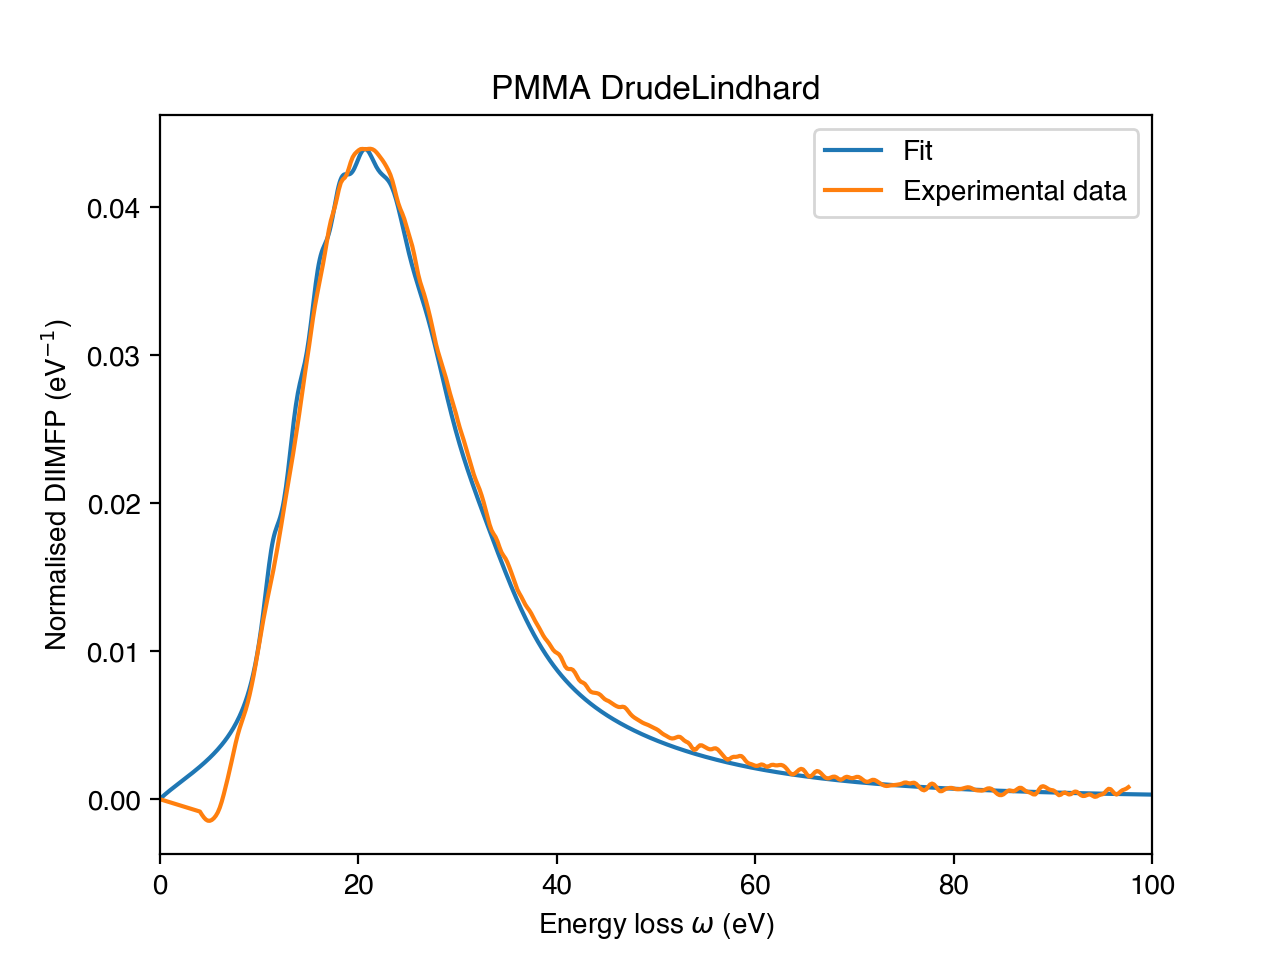

In [82]:
E0 = 1600 
eloss, w = diimfp(oscParams, E0, 11)
w_normalised = w / np.trapz(w, eloss)

fd = pd.read_csv(f'diimfp/{oscParams.name}_diimfp.dat',sep=' ',header=None)
exp_diimfp = fd.values

plt.figure()
plt.plot(eloss,w_normalised,label='Fit')
plt.plot(exp_diimfp[:,0],exp_diimfp[:,1],label='Experimental data')
plt.xlabel('Energy loss $\omega$ (eV)')
plt.ylabel('Normalised DIIMFP (eV$^{-1}$)')
plt.title(f'{oscParams.name} {oscParams.model}')
plt.legend()
plt.xlim(0,100)
plt.show()

# to save figure
# plt.savefig(f'ndiimfp_{oscParams.name}.png',dpi=600,bbox_inches='tight')

# to save data to csv
# np.savetxt(f'diimfp_{oscParams.name}.csv', np.transpose([oscParams.eloss,w,w_normalised]), header="energy(eV) diimfp ndiimfp", delimiter=" ")

*IMFP*

<IPython.core.display.Javascript object>


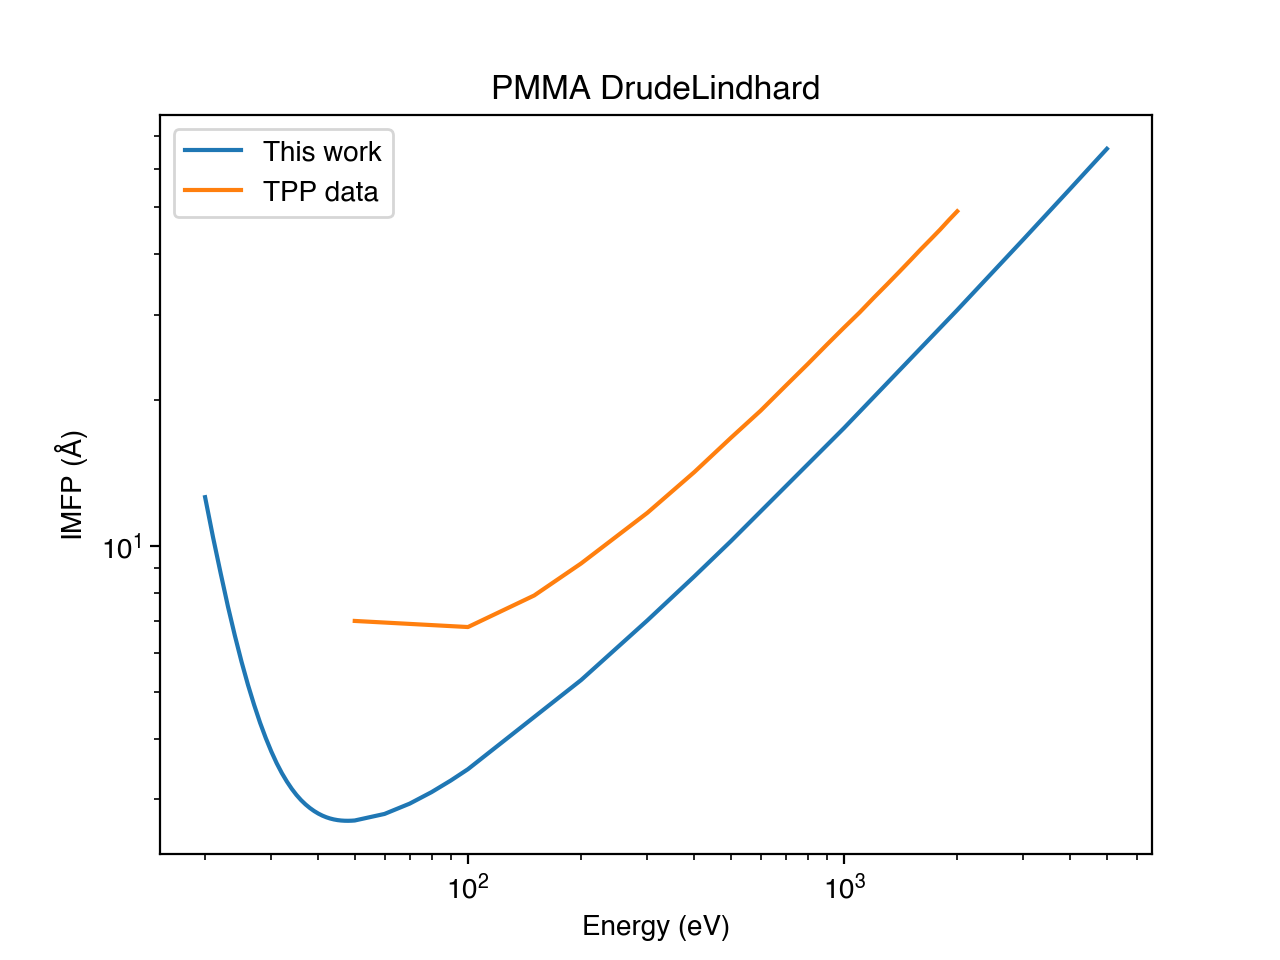

In [83]:
E0 = np.hstack((linspace(20,50),linspace(60,100,10),linspace(200,500,100),linspace(1000,5000,1000)))
lin = imfp(oscParams,E0)

plt.figure()
plt.plot(E0, lin,label='This work')
plt.plot(tpp_data[:,0],tpp_data[:,12],label='TPP data')
plt.xlabel('Energy (eV)')
plt.ylabel('IMFP ($\mathrm{\AA}$)')
plt.yscale('log')
plt.xscale('log')
plt.title(f'{oscParams.name} {oscParams.model}')
plt.legend()
plt.show()

# to save figure
# plt.savefig(f'imfp_{oscParams.name}.png',dpi=600,bbox_inches='tight')

# to save data to csv
# np.savetxt(f'imfp_{oscParams.name}.csv', np.transpose([E0,lin]), header="energy(eV) imfp(A)", delimiter=" ")

**PE**

In [87]:
oscParams = Osc()
oscParams.model = 'Drude'
oscParams.name = 'PE'
oscParams.composition = {'element': ['c','h'], 'index': [2,4]}
oscParams.A = np.array([3096.49, 3386.26, 3383.68, 2932.40, 2606.66, 2710.75, 2745.19, 1094.67, 1213.62, 1809.36, 2092.78, 3412.72, 2053.60, 844.71])*0.01
oscParams.gamma = np.array([0.6, 1.5, 2.6, 2.9, 3.6, 11.9, 4.4, 3.4, 3.9, 6.7, 12.1, 14.3, 16.8, 89.7])
oscParams.omega = np.array([7.9, 8.4, 9.7, 10.9, 12.5, 14.8, 14.9, 17.3, 19.5, 22.2, 26.0, 26.1, 31.2, 72.0])
oscParams.alpha = 0
# oscParams.eloss = linspace(machine_eps,100,0.1)
oscParams.eloss = linspace(0.5,100,0.5)
oscParams.q = np.array([0])
oscParams.Eg = 7.5
oscParams.vb = 6
oscParams.na = 0.1210667997

In [ ]:
oscParams = Osc()
oscParams.model = 'Drude'
oscParams.name = 'PE'
oscParams.composition = {'element': ['c','h'], 'index': [2,4]}
oscParams.A = np.array([3096.49, 3386.26, 3383.68, 2932.40, 2606.66, 2710.75, 2745.19, 1094.67, 1213.62, 1809.36, 2092.78, 3412.72, 2053.60, 844.71])*0.01
oscParams.gamma = np.array([0.6, 1.5, 2.6, 2.9, 3.6, 11.9, 4.4, 3.4, 3.9, 6.7, 12.1, 14.3, 16.8, 89.7])
oscParams.omega = np.array([7.9, 8.4, 9.7, 10.9, 12.5, 14.8, 14.9, 17.3, 19.5, 22.2, 26.0, 26.1, 31.2, 72.0])
oscParams.alpha = 0
oscParams.eloss = linspace(machine_eps,100,0.1)
oscParams.q = np.array([0])
oscParams.Eg = 7.5
oscParams.vb = 6
oscParams.na = 0.1210667997

*Dielectric function*

<IPython.core.display.Javascript object>


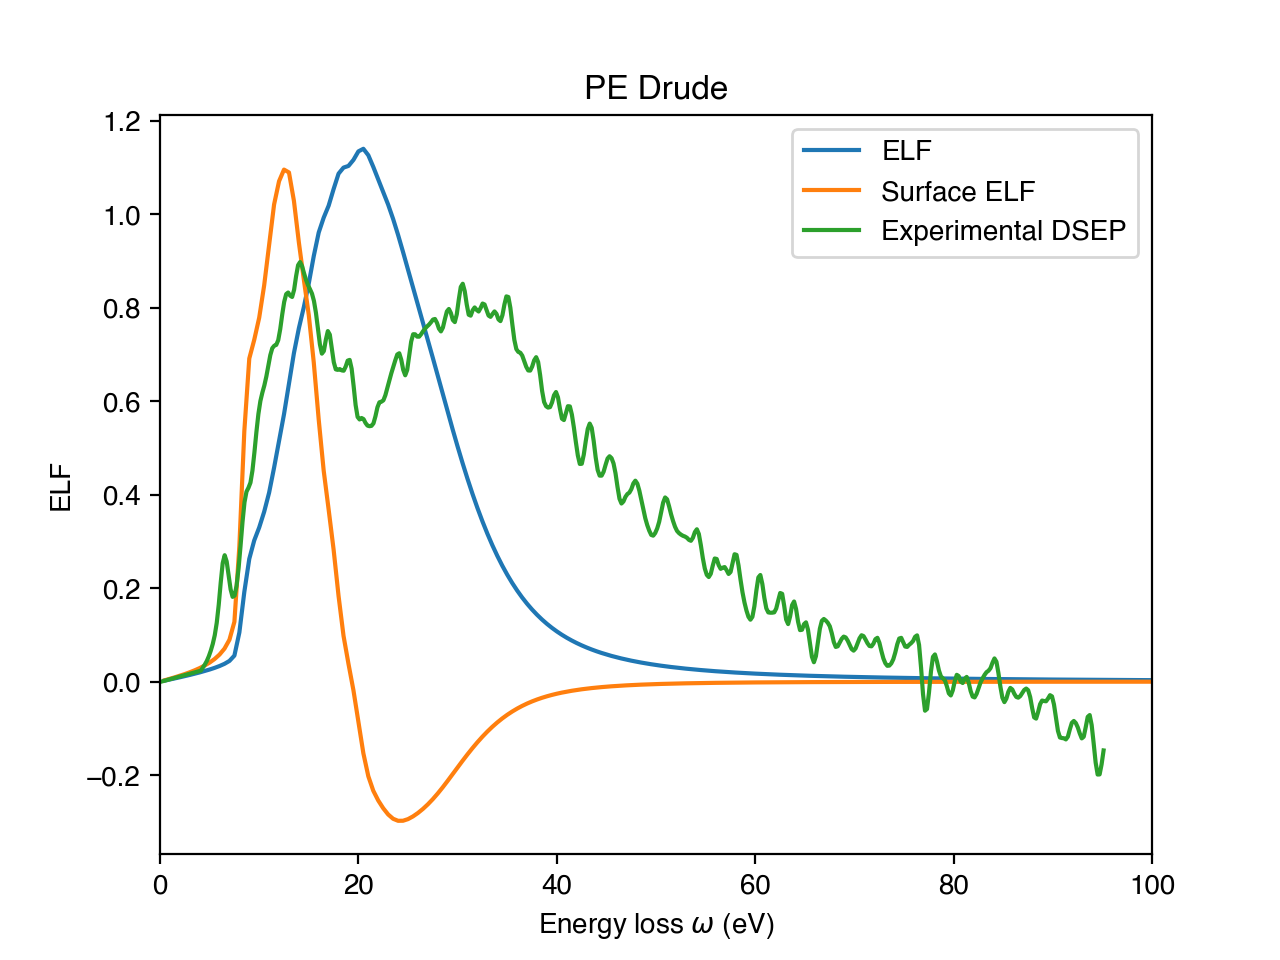

In [88]:
eps = eps_sum(oscParams)

eps_1 = eps.real
eps_2 = eps.imag
den = (eps_1**2 + eps_1 - eps_2**2)**2 + (2*eps_1*eps_2 + eps_2)**2
enu = -eps_2*(2*eps_1 + 1)*((eps_1 - 1)**2 - eps_2**2)
enu += 2*eps_2*(eps_1 - 1)*(eps_1*(eps_1 + 1) - eps_2**2)
surf_elf = enu/den

# extending the ELF with the Henke ionisation data to higher energy losses
#=========================================================================
# energy_henke, elf_henke = mopt(oscParams.composition, oscParams.na)
# ind_henke = energy_henke > 100
# ind = oscParams.eloss <= 100
# eloss = np.concatenate((oscParams.eloss[ind],energy_henke[ind_henke]))
# elf = np.concatenate(((-1/eps).imag[ind],elf_henke[ind_henke]))
# plt.plot(eloss,elf)
#=========================================================================

fd = pd.read_csv(f'../MATLAB/dsep/{oscParams.name}_dsep.dat',sep=' ',header=None)
exp_dsep = fd.values

plt.figure()
# plt.plot(oscParams.eloss,eps.real,label='$\epsilon_1$')
# plt.plot(oscParams.eloss,eps.imag,label='$\epsilon_2$')
plt.plot(oscParams.eloss,(-1/eps).imag,label='ELF')
plt.plot(oscParams.eloss,surf_elf,label='Surface ELF')
plt.plot(exp_dsep[:,0],exp_dsep[:,1]*65,label='Experimental DSEP')

plt.xlabel('Energy loss $\omega$ (eV)')
plt.ylabel('ELF')
plt.title(f'{oscParams.name} {oscParams.model}')
plt.xlim(0,100)
plt.legend()
plt.show()

plt.savefig(f'{oscParams.name}_{oscParams.model}_surface.png',dpi=600)

# to save figure
# plt.savefig(f'epsilon_{oscParams.name}.png',dpi=600,bbox_inches='tight')

# to save data to csv
# np.savetxt(f'epsilon_{oscParams.name}.csv', np.transpose([oscParams.eloss,eps.real,eps.imag,(-1/eps).imag]), header="energy(eV) epsilon1 epsilon2 elf", delimiter=" ")

<IPython.core.display.Javascript object>


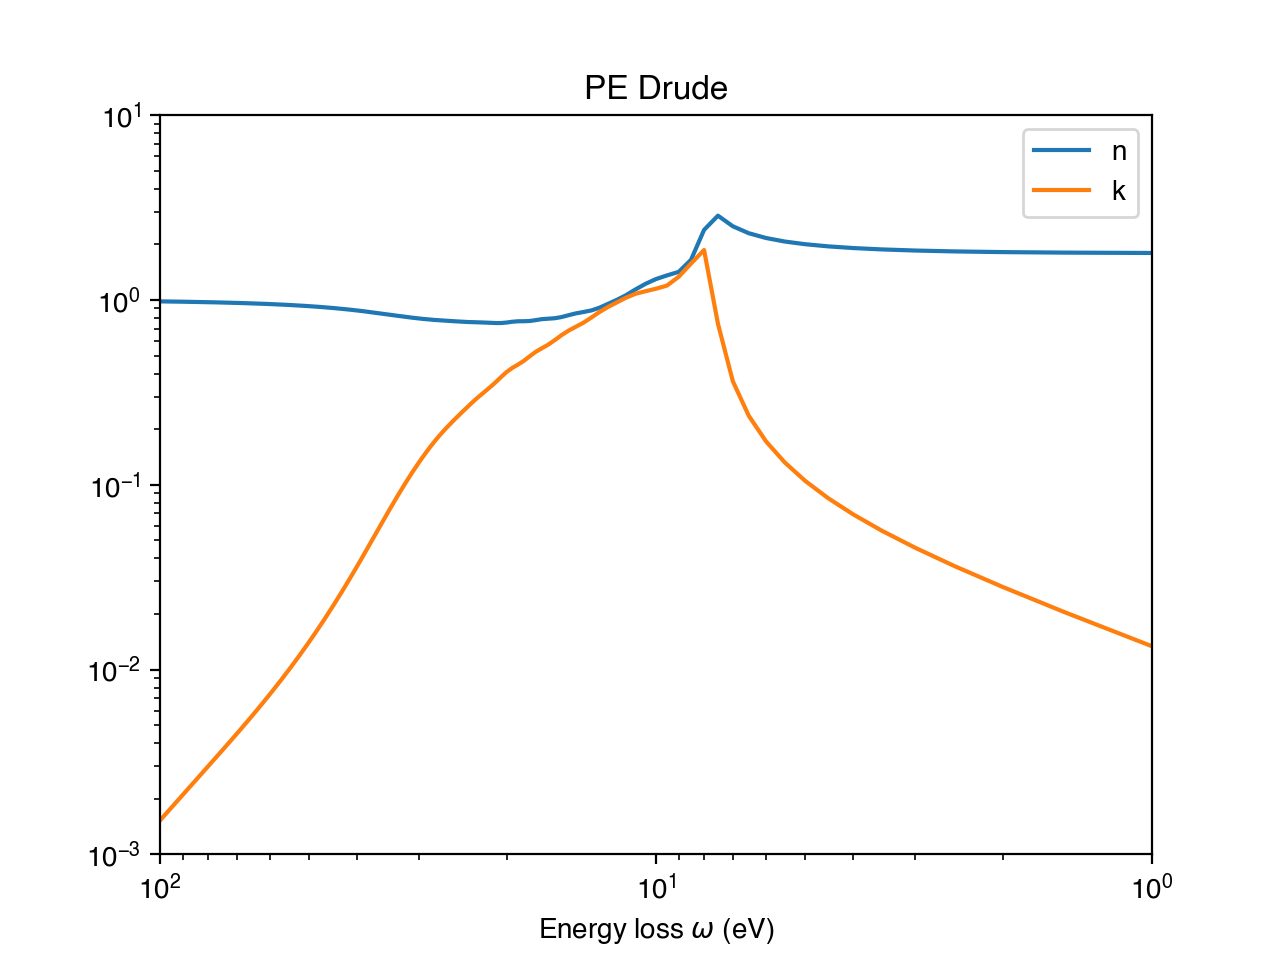

In [89]:
n_complex = np.sqrt(eps)
n = n_complex.real
k = n_complex.imag

plt.figure()
plt.plot(oscParams.eloss,n,label='n')
plt.plot(oscParams.eloss,k,label='k')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Energy loss $\omega$ (eV)')
plt.xlim(100,1)
plt.ylim(0.001,10)
plt.legend()
plt.title(f'{oscParams.name} {oscParams.model}')
plt.show()

In [90]:
d  = dict(E=np.round(oscParams.eloss,2),n=np.round(n,2),k=np.round(k,2),eps1=np.round(eps_1,2), eps2=np.round(eps_2,2), elf=np.round((-1/eps).imag,2))
df = pd.DataFrame.from_dict(d, orient='index').transpose().fillna('')

caption = f'Values of the real $\\epsilon_1$ and imaginary $\\epsilon_2$ parts of the complex dielectric constant and the ELF Im$\\left( -1/\\epsilon \\right)$ of {oscParams.name} derived from the REELS data based on the {oscParams.model} model dielectric function.'
print(df.to_latex(index=False, header=['E','$n$','$k$','$\\epsilon_1$','$\\epsilon_2$','ELF'],escape=False,caption=caption,column_format='cccccc',label=f'tab:{oscParams.name}_opt_data_table'))

with open(f'{oscParams.name}_{oscParams.model}_table_optical_data.tex', 'w') as tf:
     tf.write(df.to_latex(index=False, header=['E','$n$','$k$','$\\epsilon_1$','$\\epsilon_2$','ELF'],escape=False,caption=caption,column_format='cccccc',label=f'tab:{oscParams.name}_opt_data_table'))

\begin{table}
\centering
\caption{Values of the real $\epsilon_1$ and imaginary $\epsilon_2$ parts of the complex dielectric constant and the ELF Im$\left( -1/\epsilon \right)$ of PE derived from the REELS data based on the Drude model dielectric function.}
\label{tab:PE_opt_data_table}
\begin{tabular}{cccccc}
\toprule
     E &   $n$ &   $k$ & $\epsilon_1$ & $\epsilon_2$ &   ELF \\
\midrule
   0.5 &  1.79 &  0.01 &         3.21 &         0.02 &  0.00 \\
   1.0 &  1.80 &  0.01 &         3.23 &         0.05 &  0.00 \\
   1.5 &  1.80 &  0.02 &         3.26 &         0.07 &  0.01 \\
   2.0 &  1.82 &  0.03 &         3.30 &         0.10 &  0.01 \\
   2.5 &  1.83 &  0.04 &         3.35 &         0.13 &  0.01 \\
   3.0 &  1.85 &  0.05 &         3.43 &         0.17 &  0.01 \\
   3.5 &  1.88 &  0.06 &         3.52 &         0.21 &  0.02 \\
   4.0 &  1.91 &  0.07 &         3.64 &         0.26 &  0.02 \\
   4.5 &  1.95 &  0.08 &         3.80 &         0.33 &  0.02 \\
   5.0 &  2.00 &  0.10 &      

*normalised DIIMFP*

<IPython.core.display.Javascript object>


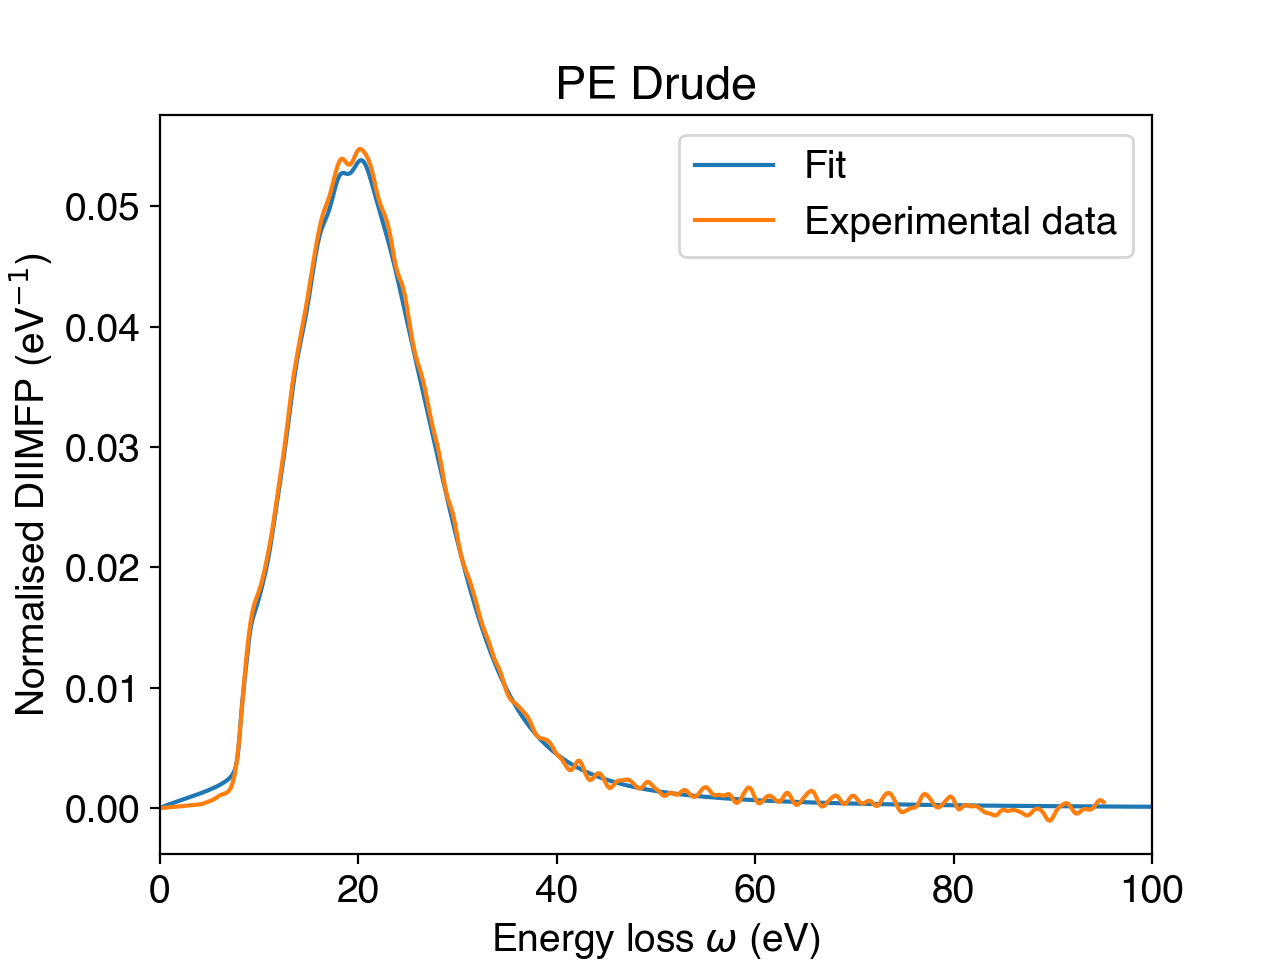

In [82]:
E0 = 1600 
eloss, w = diimfp(oscParams, E0, 11)
w_normalised = w / np.trapz(w, eloss)

fd = pd.read_csv(f'diimfp/{oscParams.name}_diimfp.dat',sep=' ',header=None)
exp_diimfp = fd.values

plt.figure()
plt.plot(eloss,w_normalised,label='Fit')
plt.plot(exp_diimfp[:,0],exp_diimfp[:,1],label='Experimental data')
plt.xlabel('Energy loss $\omega$ (eV)')
plt.ylabel('Normalised DIIMFP (eV$^{-1}$)')
plt.title(f'{oscParams.name} {oscParams.model}')
plt.legend()
plt.xlim(0,100)
plt.show()

# to save figure
# plt.savefig(f'ndiimfp_{oscParams.name}.png',dpi=600,bbox_inches='tight')

# to save data to csv
# np.savetxt(f'diimfp_{oscParams.name}.csv', np.transpose([oscParams.eloss,w,w_normalised]), header="energy(eV) diimfp ndiimfp", delimiter=" ")

*IMFP*

<IPython.core.display.Javascript object>


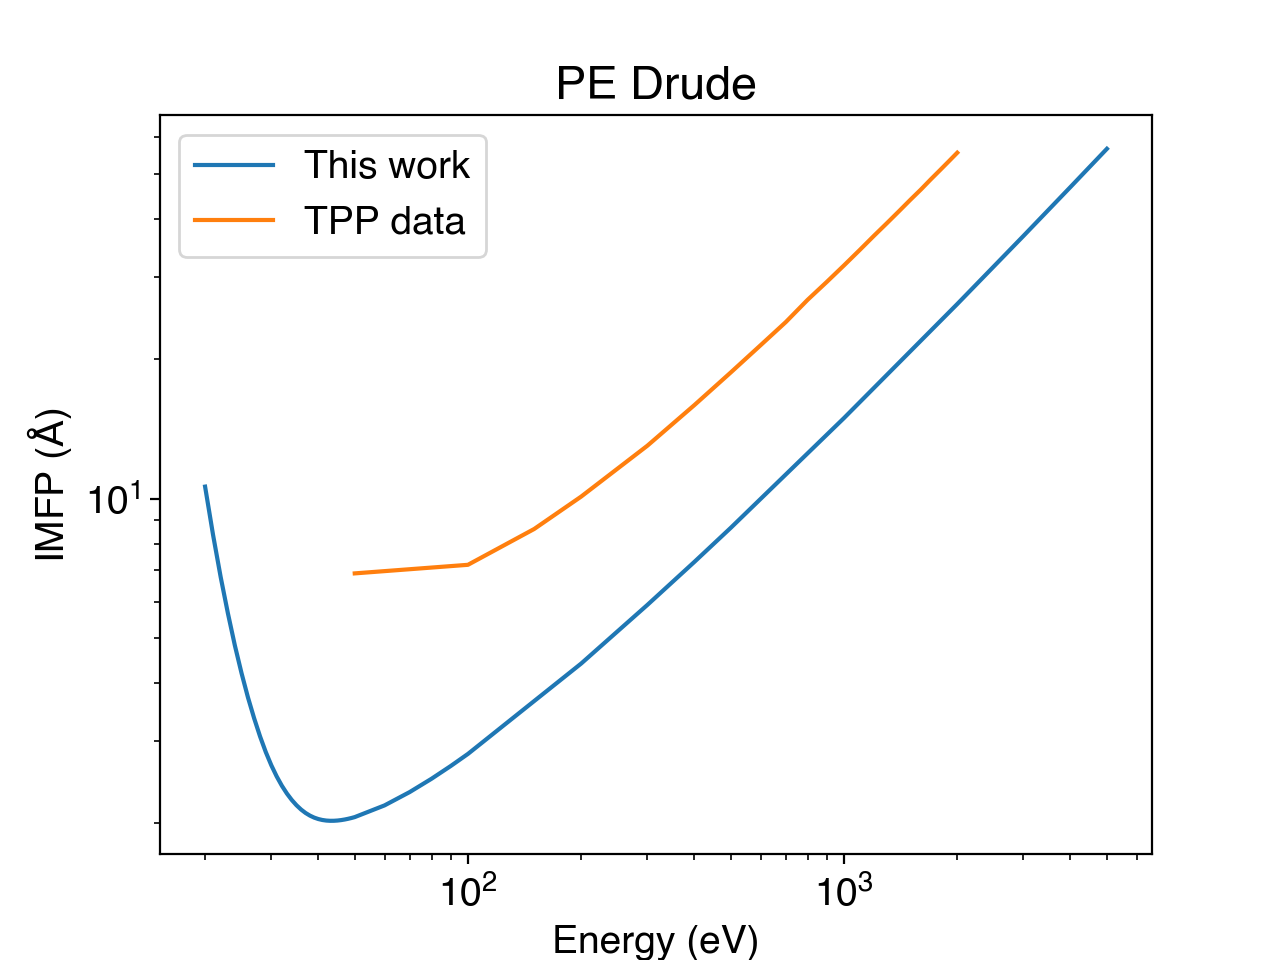

In [83]:
E0 = np.hstack((linspace(20,50),linspace(60,100,10),linspace(200,500,100),linspace(1000,5000,1000)))
lin = imfp(oscParams,E0)

plt.figure()
plt.plot(E0, lin,label='This work')
plt.plot(tpp_data[:,0],tpp_data[:,11],label='TPP data')
plt.xlabel('Energy (eV)')
plt.ylabel('IMFP ($\mathrm{\AA}$)')
plt.yscale('log')
plt.xscale('log')
plt.title(f'{oscParams.name} {oscParams.model}')
plt.legend()
plt.show()

# to save figure
# plt.savefig(f'imfp_{oscParams.name}.png',dpi=600,bbox_inches='tight')

# to save data to csv
# np.savetxt(f'imfp_{oscParams.name}.csv', np.transpose([E0,lin]), header="energy(eV) imfp(A)", delimiter=" ")

**PS**

In [91]:
oscParams = Osc()
oscParams.model = 'Drude'
oscParams.name = 'PS'
oscParams.composition = {'element': ['c','h'], 'index': [8,8]}
oscParams.A = np.array([61.94, 6.89,32.36,34.78,31.78,40.3,36.12,27.7,22.66,18.23,12.48,9.55])
oscParams.gamma = np.array([0.5,0.5,5.2,2.7,3,3.8,4.5,5.2,5.4,5.3,4.8,4.7])
oscParams.omega = np.array([5.2,8.9,9.6,9.8,11.8,14.2,17.1,20.3,23.6,27.1,30.6,34.4])
oscParams.alpha = 0
# oscParams.eloss = linspace(machine_eps,100,0.1)
oscParams.eloss = linspace(0.5,100,0.5)
oscParams.q = np.array([0])
oscParams.Eg = 5.7
oscParams.vb = 10
oscParams.na = 0.097

In [73]:
oscParams = Osc()
oscParams.model = 'DrudeLindhard'
oscParams.name = 'PS'
oscParams.composition = {'element': ['c','h'], 'index': [8,8]}
oscParams.A = np.array([0.094,0.012,0.014,0.059,0.143,0.12,0.135,0.115,0.06,0.036,0.021,0.006])
oscParams.gamma = np.array([0.96,1.1,1.71,3.27,5.09,4.17,4.56,4.83,4.21,3.99,3.84,2.63])
oscParams.omega = np.array([6.9,9.69,10.72,12.7,15.97,18.88,21.51,24.35,27.29,30.14,33.12,35.93])
oscParams.alpha = 0
oscParams.eloss = linspace(machine_eps,100,0.1)
oscParams.q = np.array([0])
oscParams.Eg = 5.7
oscParams.vb = 10
oscParams.na = 0.097

*Dielectric function*

<IPython.core.display.Javascript object>


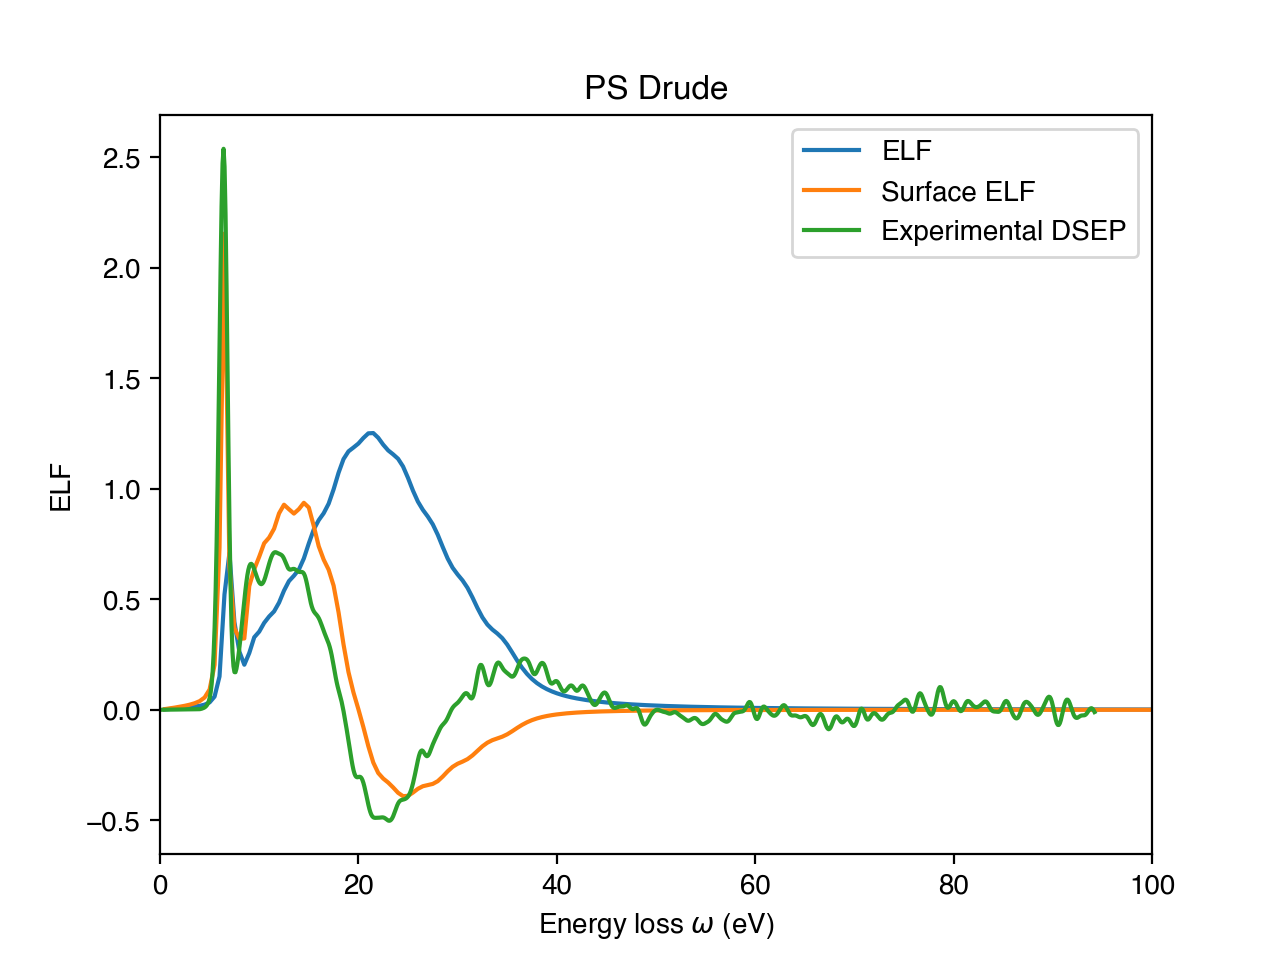

In [92]:
eps = eps_sum(oscParams)

eps_1 = eps.real
eps_2 = eps.imag
den = (eps_1**2 + eps_1 - eps_2**2)**2 + (2*eps_1*eps_2 + eps_2)**2
enu = -eps_2*(2*eps_1 + 1)*((eps_1 - 1)**2 - eps_2**2)
enu += 2*eps_2*(eps_1 - 1)*(eps_1*(eps_1 + 1) - eps_2**2)
surf_elf = enu/den

# extending the ELF with the Henke ionisation data to higher energy losses
#=========================================================================
# energy_henke, elf_henke = mopt(oscParams.composition, oscParams.na)
# ind_henke = energy_henke > 100
# ind = oscParams.eloss <= 100
# eloss = np.concatenate((oscParams.eloss[ind],energy_henke[ind_henke]))
# elf = np.concatenate(((-1/eps).imag[ind],elf_henke[ind_henke]))
# plt.plot(eloss,elf)
#=========================================================================

fd = pd.read_csv(f'../MATLAB/dsep/{oscParams.name}_dsep.dat',sep=' ',header=None)
exp_dsep = fd.values

plt.figure()
# plt.plot(oscParams.eloss,eps.real,label='$\epsilon_1$')
# plt.plot(oscParams.eloss,eps.imag,label='$\epsilon_2$')
plt.plot(oscParams.eloss,(-1/eps).imag,label='ELF')
plt.plot(oscParams.eloss,surf_elf,label='Surface ELF')
plt.plot(exp_dsep[:,0],exp_dsep[:,1]*25,label='Experimental DSEP')

plt.xlabel('Energy loss $\omega$ (eV)')
plt.ylabel('ELF')
plt.title(f'{oscParams.name} {oscParams.model}')
plt.xlim(0,100)
plt.legend()
plt.show()

plt.savefig(f'{oscParams.name}_{oscParams.model}_surface.png',dpi=600)

<IPython.core.display.Javascript object>


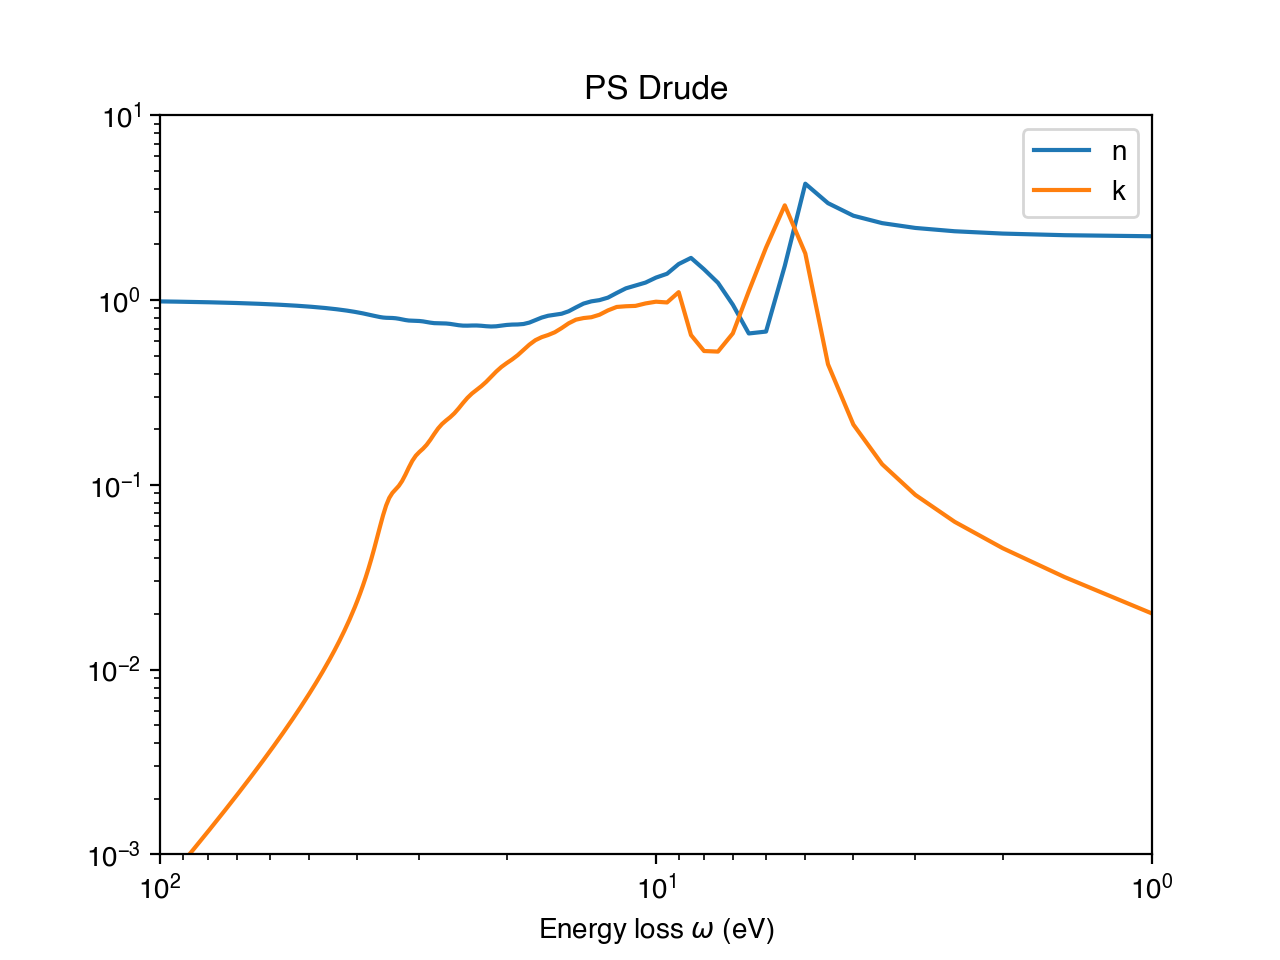

In [93]:
n_complex = np.sqrt(eps)
n = n_complex.real
k = n_complex.imag

plt.figure()
plt.plot(oscParams.eloss,n,label='n')
plt.plot(oscParams.eloss,k,label='k')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Energy loss $\omega$ (eV)')
plt.xlim(100,1)
plt.ylim(0.001,10)
plt.legend()
plt.title(f'{oscParams.name} {oscParams.model}')
plt.show()

In [94]:
d  = dict(E=np.round(oscParams.eloss,2),n=np.round(n,2),k=np.round(k,2),eps1=np.round(eps_1,2), eps2=np.round(eps_2,2), elf=np.round((-1/eps).imag,2))
df = pd.DataFrame.from_dict(d, orient='index').transpose().fillna('')

caption = f'Values of the real $\\epsilon_1$ and imaginary $\\epsilon_2$ parts of the complex dielectric constant and the ELF Im$\\left( -1/\\epsilon \\right)$ of {oscParams.name} derived from the REELS data based on the {oscParams.model} model dielectric function.'
print(df.to_latex(index=False, header=['E','$n$','$k$','$\\epsilon_1$','$\\epsilon_2$','ELF'],escape=False,caption=caption,column_format='cccccc',label=f'tab:{oscParams.name}_opt_data_table'))

with open(f'{oscParams.name}_{oscParams.model}_table_optical_data.tex', 'w') as tf:
     tf.write(df.to_latex(index=False, header=['E','$n$','$k$','$\\epsilon_1$','$\\epsilon_2$','ELF'],escape=False,caption=caption,column_format='cccccc',label=f'tab:{oscParams.name}_opt_data_table'))

\begin{table}
\centering
\caption{Values of the real $\epsilon_1$ and imaginary $\epsilon_2$ parts of the complex dielectric constant and the ELF Im$\left( -1/\epsilon \right)$ of PS derived from the REELS data based on the Drude model dielectric function.}
\label{tab:PS_opt_data_table}
\begin{tabular}{cccccc}
\toprule
     E &   $n$ &   $k$ & $\epsilon_1$ & $\epsilon_2$ &   ELF \\
\midrule
   0.5 &  2.20 &  0.01 &         4.82 &         0.04 &  0.00 \\
   1.0 &  2.21 &  0.02 &         4.89 &         0.09 &  0.00 \\
   1.5 &  2.24 &  0.03 &         5.03 &         0.14 &  0.01 \\
   2.0 &  2.29 &  0.05 &         5.23 &         0.21 &  0.01 \\
   2.5 &  2.36 &  0.06 &         5.54 &         0.30 &  0.01 \\
   3.0 &  2.45 &  0.09 &         6.02 &         0.43 &  0.01 \\
   3.5 &  2.61 &  0.13 &         6.77 &         0.67 &  0.01 \\
   4.0 &  2.86 &  0.21 &         8.12 &         1.21 &  0.02 \\
   4.5 &  3.34 &  0.45 &        10.97 &         3.00 &  0.02 \\
   5.0 &  4.26 &  1.79 &      

*Normalised DIIMFP*

<IPython.core.display.Javascript object>


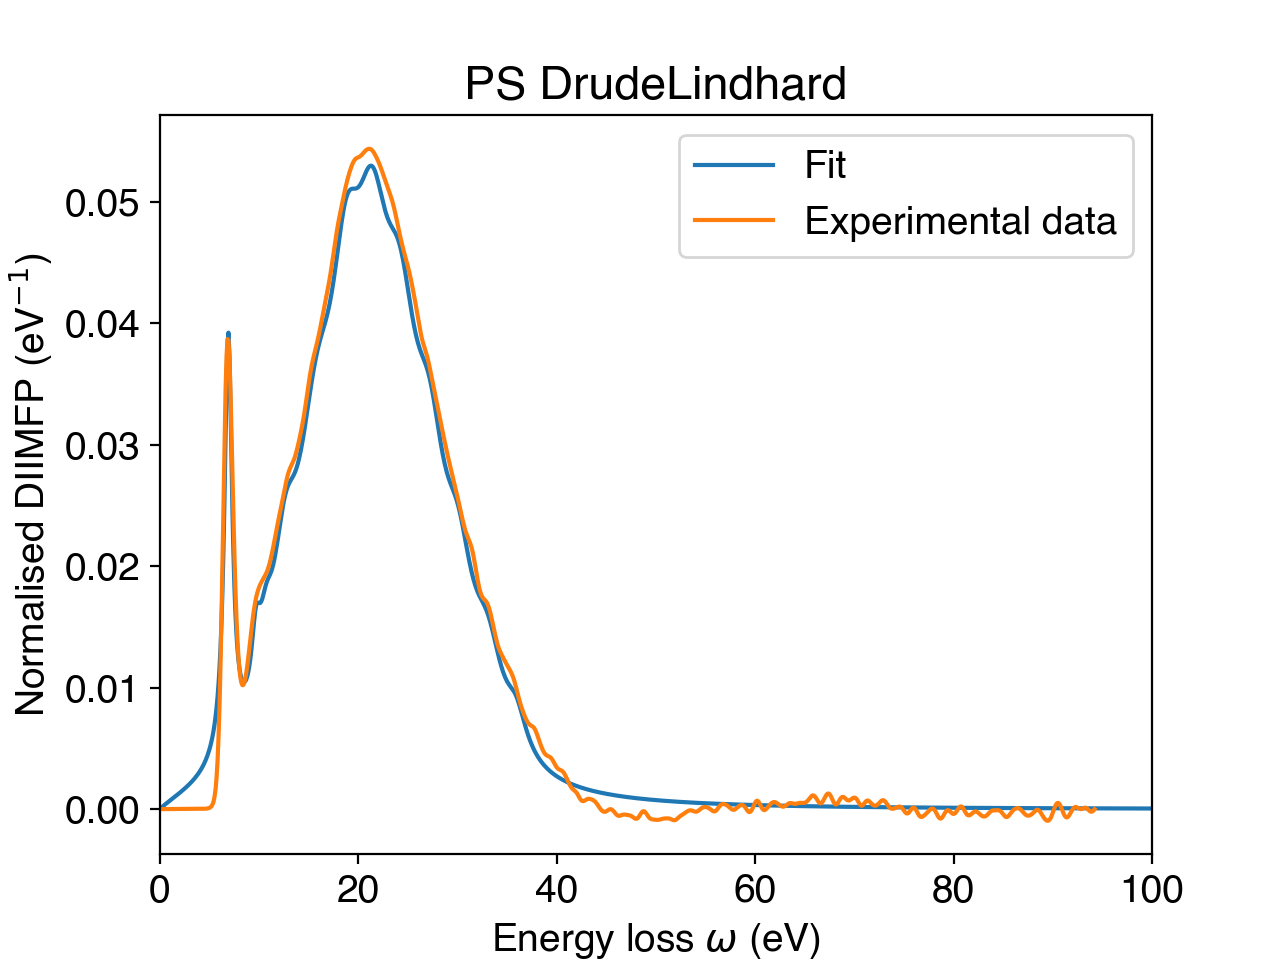

In [75]:
E0 = 1600 
eloss, w = diimfp(oscParams, E0, 11)
w_normalised = w / np.trapz(w, eloss)

fd = pd.read_csv(f'diimfp/{oscParams.name}_diimfp.dat',sep=' ',header=None)
exp_diimfp = fd.values

plt.figure()
plt.plot(eloss,w_normalised,label='Fit')
plt.plot(exp_diimfp[:,0],exp_diimfp[:,1],label='Experimental data')
plt.xlabel('Energy loss $\omega$ (eV)')
plt.ylabel('Normalised DIIMFP (eV$^{-1}$)')
plt.title(f'{oscParams.name} {oscParams.model}')
plt.legend()
plt.xlim(0,100)
plt.show()

*IMFP*

<IPython.core.display.Javascript object>


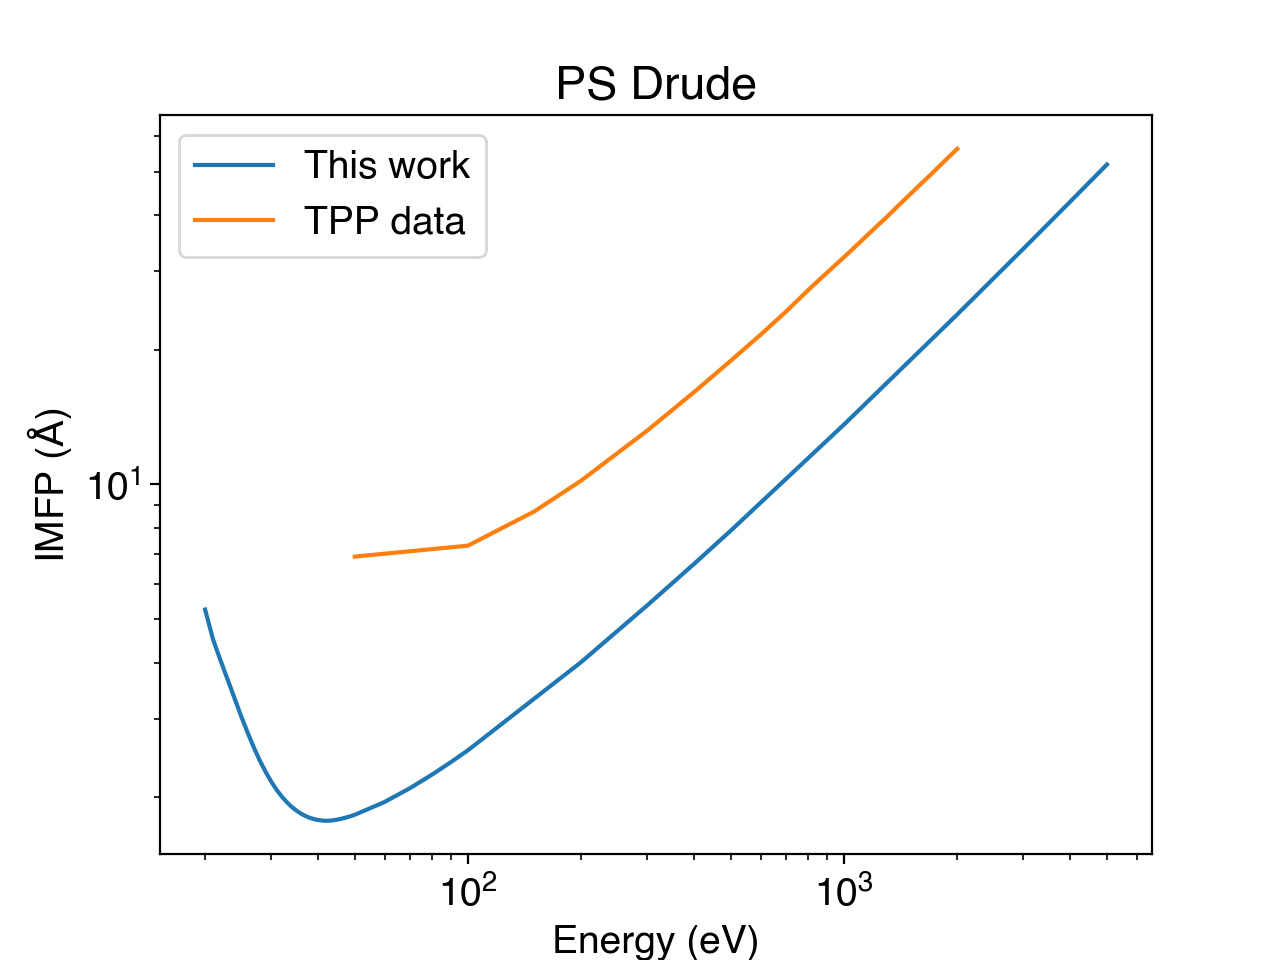

In [80]:
E0 = np.hstack((linspace(20,50),linspace(60,100,10),linspace(200,500,100),linspace(1000,5000,1000)))
lin = imfp(oscParams,E0)

plt.figure()
plt.plot(E0, lin,label='This work')
plt.plot(tpp_data[:,0],tpp_data[:,13],label='TPP data')
plt.xlabel('Energy (eV)')
plt.ylabel('IMFP ($\mathrm{\AA}$)')
plt.yscale('log')
plt.xscale('log')
plt.title(f'{oscParams.name} {oscParams.model}')
plt.legend()
plt.show()

# to save figure
# plt.savefig(f'imfp_{oscParams.name}.png',dpi=600,bbox_inches='tight')

# to save data to csv
# np.savetxt(f'imfp_{oscParams.name}.csv', np.transpose([E0,lin]), header="energy(eV) imfp(A)", delimiter=" ")

**PTFE**

In [95]:
oscParams = Osc()
oscParams.model = 'Drude'
oscParams.name = 'PTFE'
oscParams.composition = {'element': ['c','f'], 'index': [2,4]}
oscParams.A = np.array([0.93,3.87,39.19,15.06,38.65,92.64,105,185,168.28])
oscParams.gamma = np.array([0.4,1.04,3.27,4.6,5.28,11.81,21.96,41.3,191.86])
oscParams.omega = np.array([7.94,12.38,15.57,19.54,20.42,26.11,36.96,52.95,86.83])
oscParams.alpha = 0
# oscParams.eloss = linspace(machine_eps,100,0.1)
oscParams.eloss = linspace(0.5,100,0.5)
oscParams.q = np.array([0])
oscParams.Eg = 7.2
oscParams.vb = 5.5
oscParams.na = 0.078

In [70]:
oscParams = Osc()
oscParams.model = 'DrudeLindhard'
oscParams.name = 'PTFE'
oscParams.composition = {'element': ['c','f'], 'index': [2,4]}
oscParams.A = np.array([0.006,0.007,0.038,0.02,0.061,0.047,0.029,0.016,0.057,0.04,0.06,0.062])
oscParams.gamma = np.array([0.49,1.12,2.82,3.47,4.2,4.99,4.41,3.75,9.12,12.15,24.65,60.22])
oscParams.omega = np.array([8.01,12.63,16.21,18,21.26,24.26,27.08,29.39,33.15,39.96,49.89,65.47])
oscParams.alpha = 0
oscParams.eloss = linspace(machine_eps,100,0.1)
oscParams.q = np.array([0])
oscParams.Eg = 7.2
oscParams.vb = 5.5
oscParams.na = 0.078

*Dielectric function*

<IPython.core.display.Javascript object>


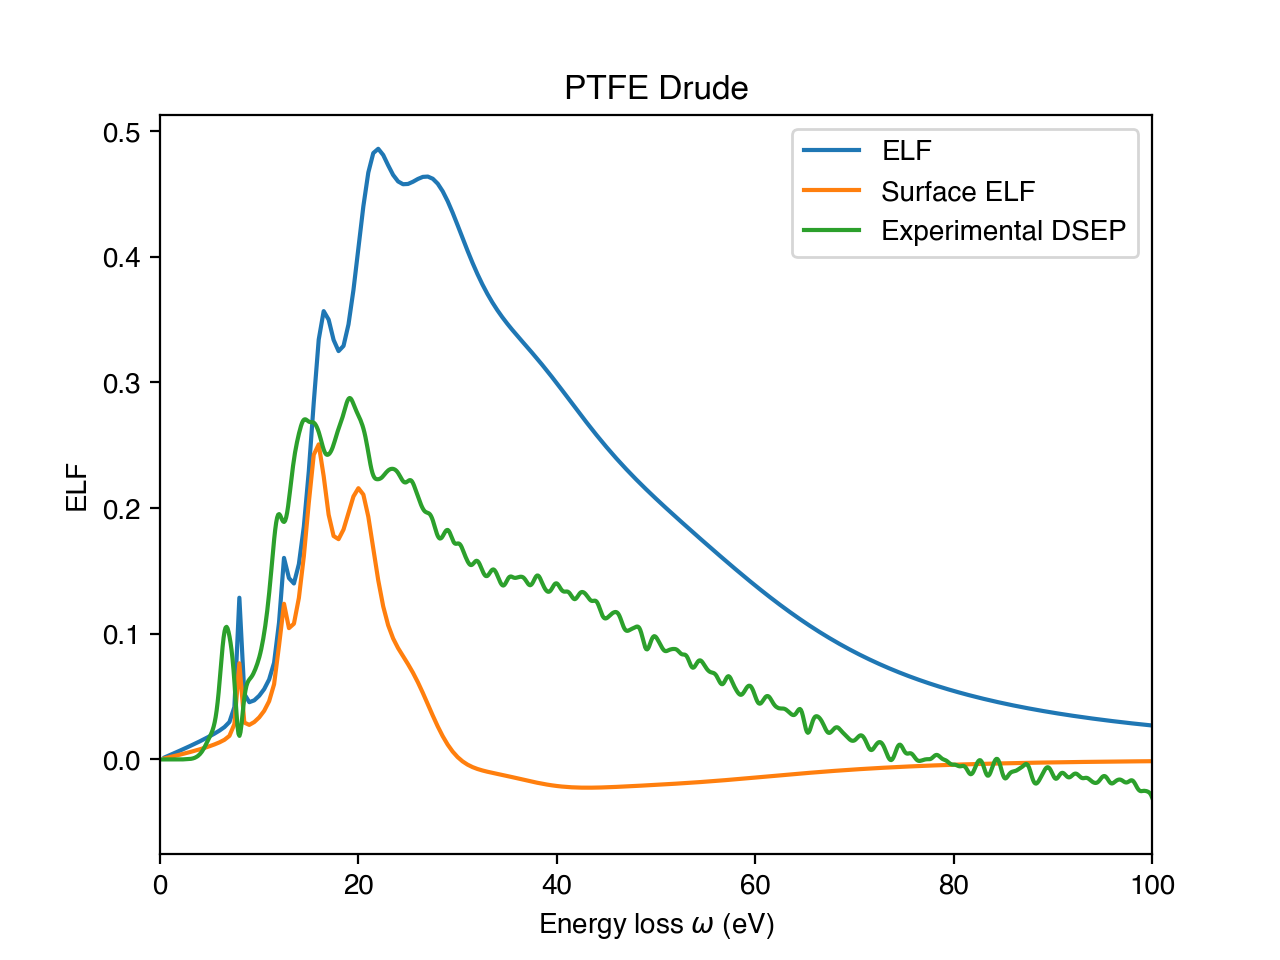

In [96]:
eps = eps_sum(oscParams)

eps_1 = eps.real
eps_2 = eps.imag
den = (eps_1**2 + eps_1 - eps_2**2)**2 + (2*eps_1*eps_2 + eps_2)**2
enu = -eps_2*(2*eps_1 + 1)*((eps_1 - 1)**2 - eps_2**2)
enu += 2*eps_2*(eps_1 - 1)*(eps_1*(eps_1 + 1) - eps_2**2)
surf_elf = enu/den

# extending the ELF with the Henke ionisation data to higher energy losses
#=========================================================================
# energy_henke, elf_henke = mopt(oscParams.composition, oscParams.na)
# ind_henke = energy_henke > 100
# ind = oscParams.eloss <= 100
# eloss = np.concatenate((oscParams.eloss[ind],energy_henke[ind_henke]))
# elf = np.concatenate(((-1/eps).imag[ind],elf_henke[ind_henke]))
# plt.plot(eloss,elf)
#=========================================================================

fd = pd.read_csv(f'../MATLAB/dsep/{oscParams.name}_dsep.dat',sep=' ',header=None)
exp_dsep = fd.values

plt.figure()
# plt.plot(oscParams.eloss,eps.real,label='$\epsilon_1$')
# plt.plot(oscParams.eloss,eps.imag,label='$\epsilon_2$')
plt.plot(oscParams.eloss,(-1/eps).imag,label='ELF')
plt.plot(oscParams.eloss,surf_elf,label='Surface ELF')
plt.plot(exp_dsep[:,0],exp_dsep[:,1]*7,label='Experimental DSEP')

plt.xlabel('Energy loss $\omega$ (eV)')
plt.ylabel('ELF')
plt.title(f'{oscParams.name} {oscParams.model}')
plt.xlim(0,100)
plt.legend()
plt.show()

plt.savefig(f'{oscParams.name}_{oscParams.model}_surface.png',dpi=600)

<IPython.core.display.Javascript object>


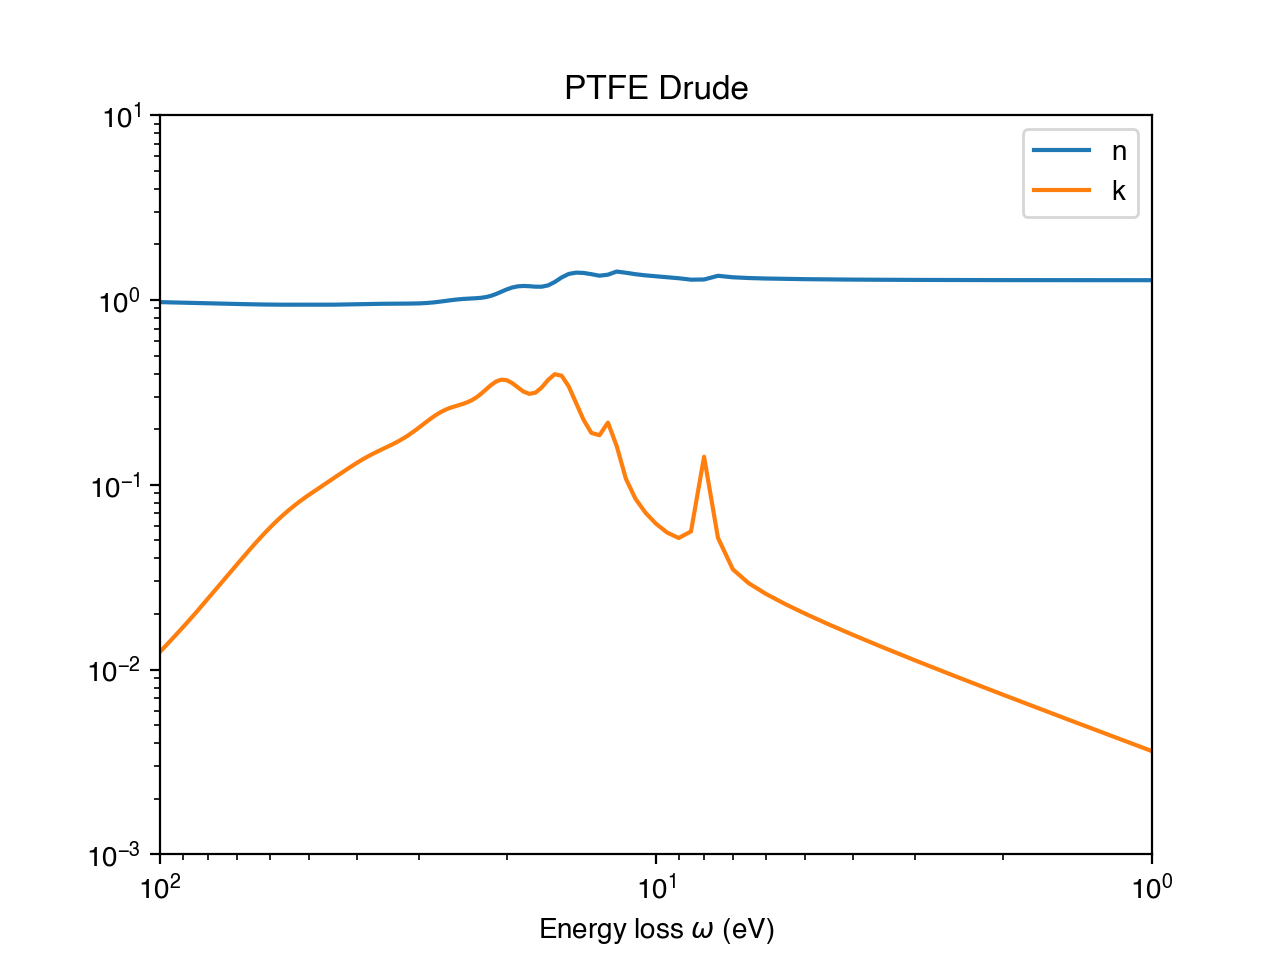

In [97]:
n_complex = np.sqrt(eps)
n = n_complex.real
k = n_complex.imag

plt.figure()
plt.plot(oscParams.eloss,n,label='n')
plt.plot(oscParams.eloss,k,label='k')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Energy loss $\omega$ (eV)')
plt.xlim(100,1)
plt.ylim(0.001,10)
plt.legend()
plt.title(f'{oscParams.name} {oscParams.model}')
plt.show()

In [98]:
d  = dict(E=np.round(oscParams.eloss,2),n=np.round(n,2),k=np.round(k,2),eps1=np.round(eps_1,2), eps2=np.round(eps_2,2), elf=np.round((-1/eps).imag,2))
df = pd.DataFrame.from_dict(d, orient='index').transpose().fillna('')

caption = f'Values of the real $\\epsilon_1$ and imaginary $\\epsilon_2$ parts of the complex dielectric constant and the ELF Im$\\left( -1/\\epsilon \\right)$ of {oscParams.name} derived from the REELS data based on the {oscParams.model} model dielectric function.'
print(df.to_latex(index=False, header=['E','$n$','$k$','$\\epsilon_1$','$\\epsilon_2$','ELF'],escape=False,caption=caption,column_format='cccccc',label=f'tab:{oscParams.name}_opt_data_table'))

with open(f'{oscParams.name}_{oscParams.model}_table_optical_data.tex', 'w') as tf:
     tf.write(df.to_latex(index=False, header=['E','$n$','$k$','$\\epsilon_1$','$\\epsilon_2$','ELF'],escape=False,caption=caption,column_format='cccccc',label=f'tab:{oscParams.name}_opt_data_table'))

\begin{table}
\centering
\caption{Values of the real $\epsilon_1$ and imaginary $\epsilon_2$ parts of the complex dielectric constant and the ELF Im$\left( -1/\epsilon \right)$ of PTFE derived from the REELS data based on the Drude model dielectric function.}
\label{tab:PTFE_opt_data_table}
\begin{tabular}{cccccc}
\toprule
     E &   $n$ &   $k$ & $\epsilon_1$ & $\epsilon_2$ &   ELF \\
\midrule
   0.5 &  1.28 &  0.00 &         1.64 &         0.00 &  0.00 \\
   1.0 &  1.28 &  0.00 &         1.64 &         0.01 &  0.00 \\
   1.5 &  1.28 &  0.01 &         1.64 &         0.01 &  0.01 \\
   2.0 &  1.28 &  0.01 &         1.64 &         0.02 &  0.01 \\
   2.5 &  1.28 &  0.01 &         1.64 &         0.02 &  0.01 \\
   3.0 &  1.28 &  0.01 &         1.65 &         0.03 &  0.01 \\
   3.5 &  1.29 &  0.01 &         1.65 &         0.03 &  0.01 \\
   4.0 &  1.29 &  0.02 &         1.66 &         0.04 &  0.01 \\
   4.5 &  1.29 &  0.02 &         1.67 &         0.05 &  0.02 \\
   5.0 &  1.30 &  0.02 &  

*Normalised DIIMFP*

<IPython.core.display.Javascript object>


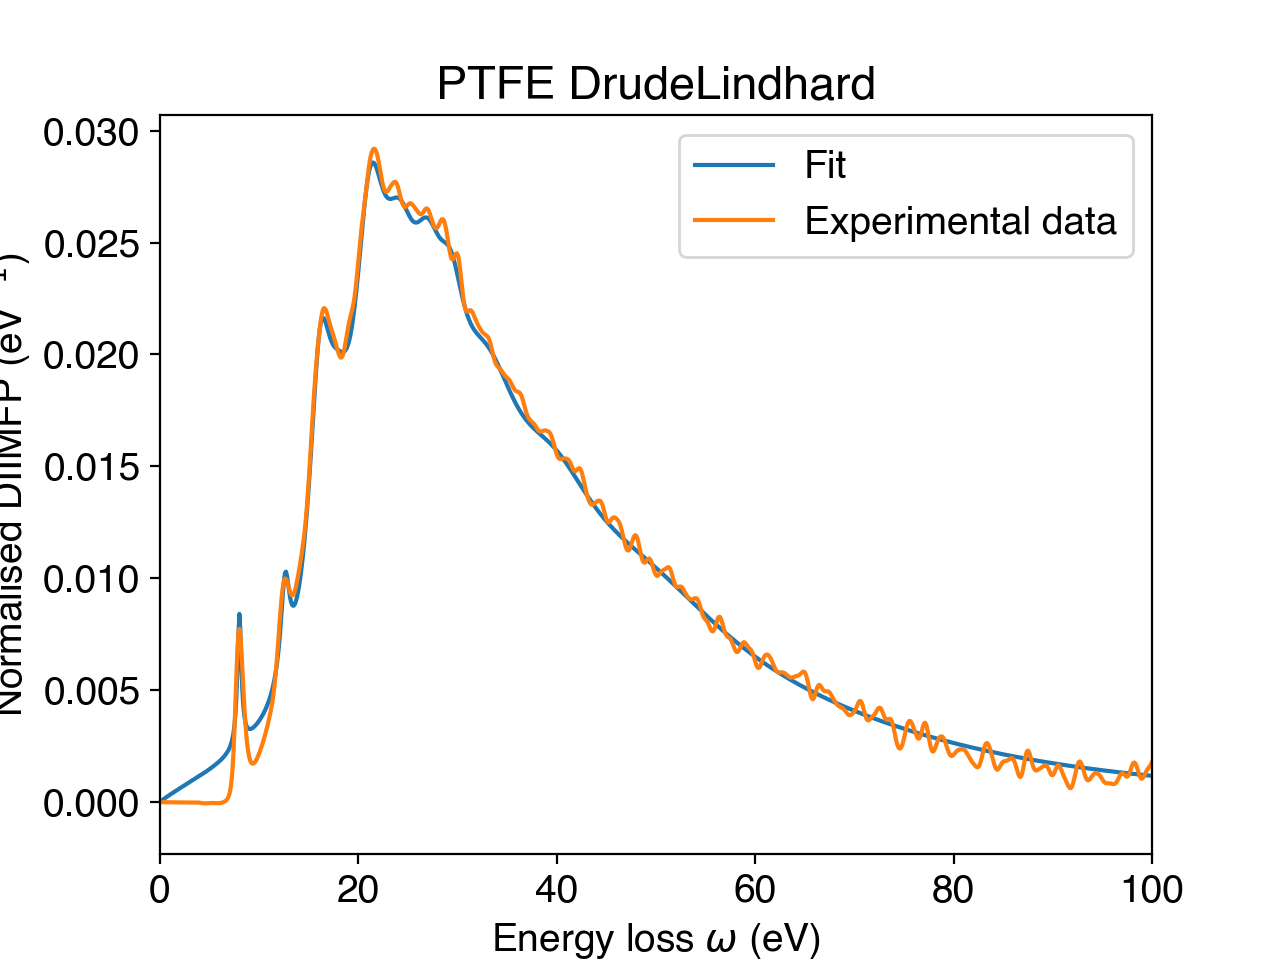

In [72]:
E0 = 1600 
eloss, w = diimfp(oscParams, E0, 11)
w_normalised = w / np.trapz(w, eloss)

fd = pd.read_csv(f'diimfp/{oscParams.name}_diimfp.dat',sep=' ',header=None)
exp_diimfp = fd.values

plt.figure()
plt.plot(eloss,w_normalised,label='Fit')
plt.plot(exp_diimfp[:,0],exp_diimfp[:,1],label='Experimental data')
plt.xlabel('Energy loss $\omega$ (eV)')
plt.ylabel('Normalised DIIMFP (eV$^{-1}$)')
plt.title(f'{oscParams.name} {oscParams.model}')
plt.legend()
plt.xlim(0,100)
plt.show()

*IMFP*

<IPython.core.display.Javascript object>


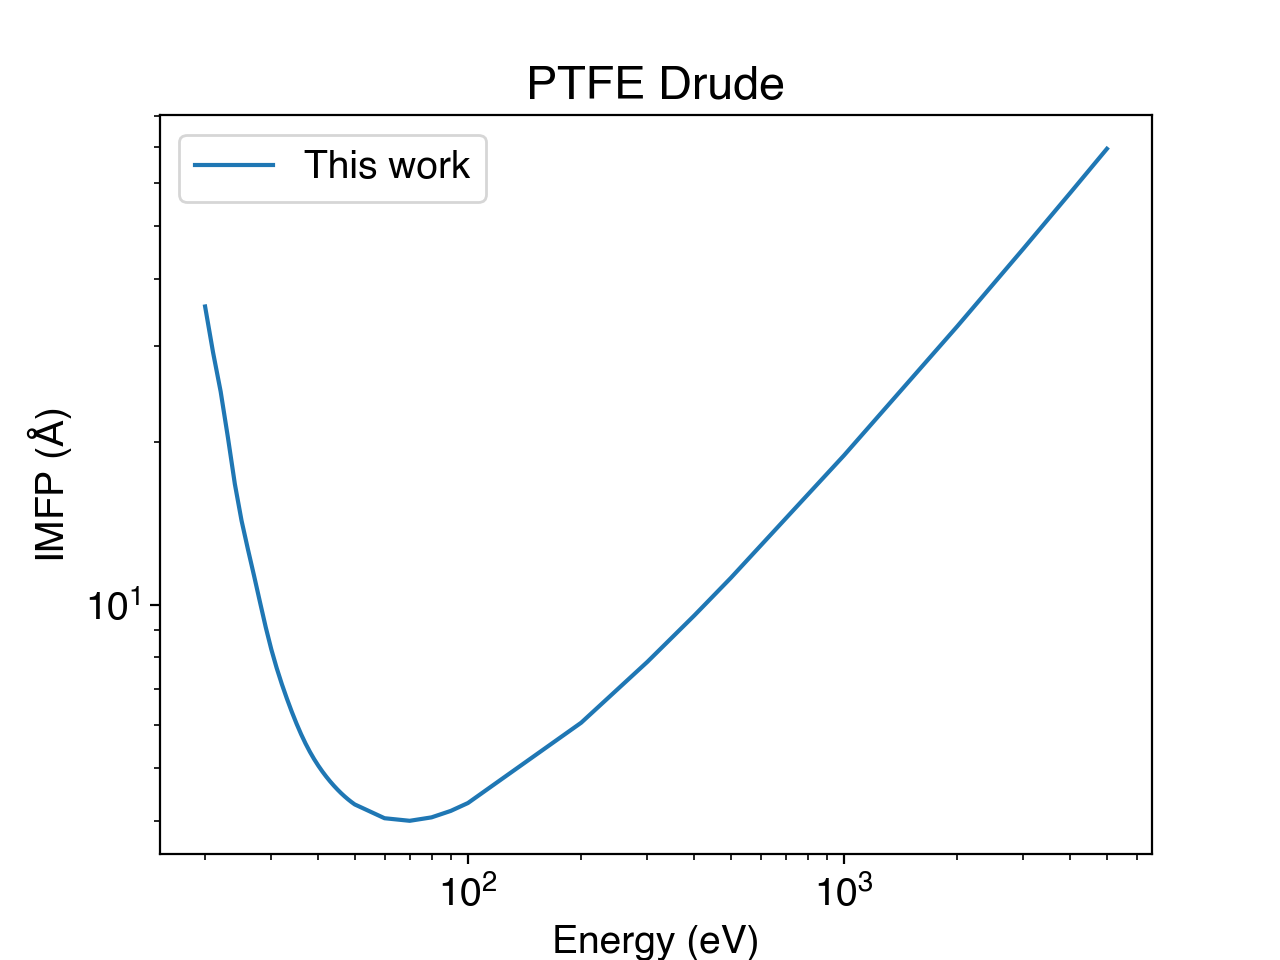

In [78]:
E0 = np.hstack((linspace(20,50),linspace(60,100,10),linspace(200,500,100),linspace(1000,5000,1000)))
lin = imfp(oscParams,E0)

plt.figure()
plt.plot(E0, lin,label='This work')
plt.xlabel('Energy (eV)')
plt.ylabel('IMFP ($\mathrm{\AA}$)')
plt.yscale('log')
plt.xscale('log')
plt.title(f'{oscParams.name} {oscParams.model}')
plt.legend()
plt.show()

# to save figure
# plt.savefig(f'imfp_{oscParams.name}.png',dpi=600,bbox_inches='tight')

# to save data to csv
# np.savetxt(f'imfp_{oscParams.name}.csv', np.transpose([E0,lin]), header="energy(eV) imfp(A)", delimiter=" ")

**Au**

In [89]:
oscParams = Osc()
oscParams.model = 'DrudeLindhard'
oscParams.name = 'Au'
oscParams.composition = {'element': ['au'], 'index': [1]}
oscParams.A = np.array([0.01, 0.02, 0.07, 0.1, 0.07,0.007, 0.16, 0.15,0.13,0.08,0.02,0.09,0.16,0.02,0.003,0.005,0.008])
oscParams.omega = np.array([2.62,3.34,6.31,10.58,17.08,25.75,25.39,33.65,39.17,45.72,52.12,14.57,64.21,96.19,278.92,210.69,470.93])
oscParams.gamma = np.array([0.29,0.81,3.05,5.62,5.04,2.05,8.04,8.56,10.86,10.79,11.13,5.39,29.85,34.51,38.38,62.79,376.54])
oscParams.alpha = 1
oscParams.eloss = np.linspace(0,100,1000)
oscParams.q = np.array([0])
oscParams.Eg = 0
oscParams.Ef = 9
oscParams.na = 0.059

In [90]:
fd = pd.read_csv('/Users/olgaridzel/Research/IMFPpaper/gnuplot/au.iimfp',sep=' ',header=None)
au_iimfp = fd.values

In [91]:
E0 = np.array([20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000]) # eV
lin = imfp(oscParams,E0)

<IPython.core.display.Javascript object>


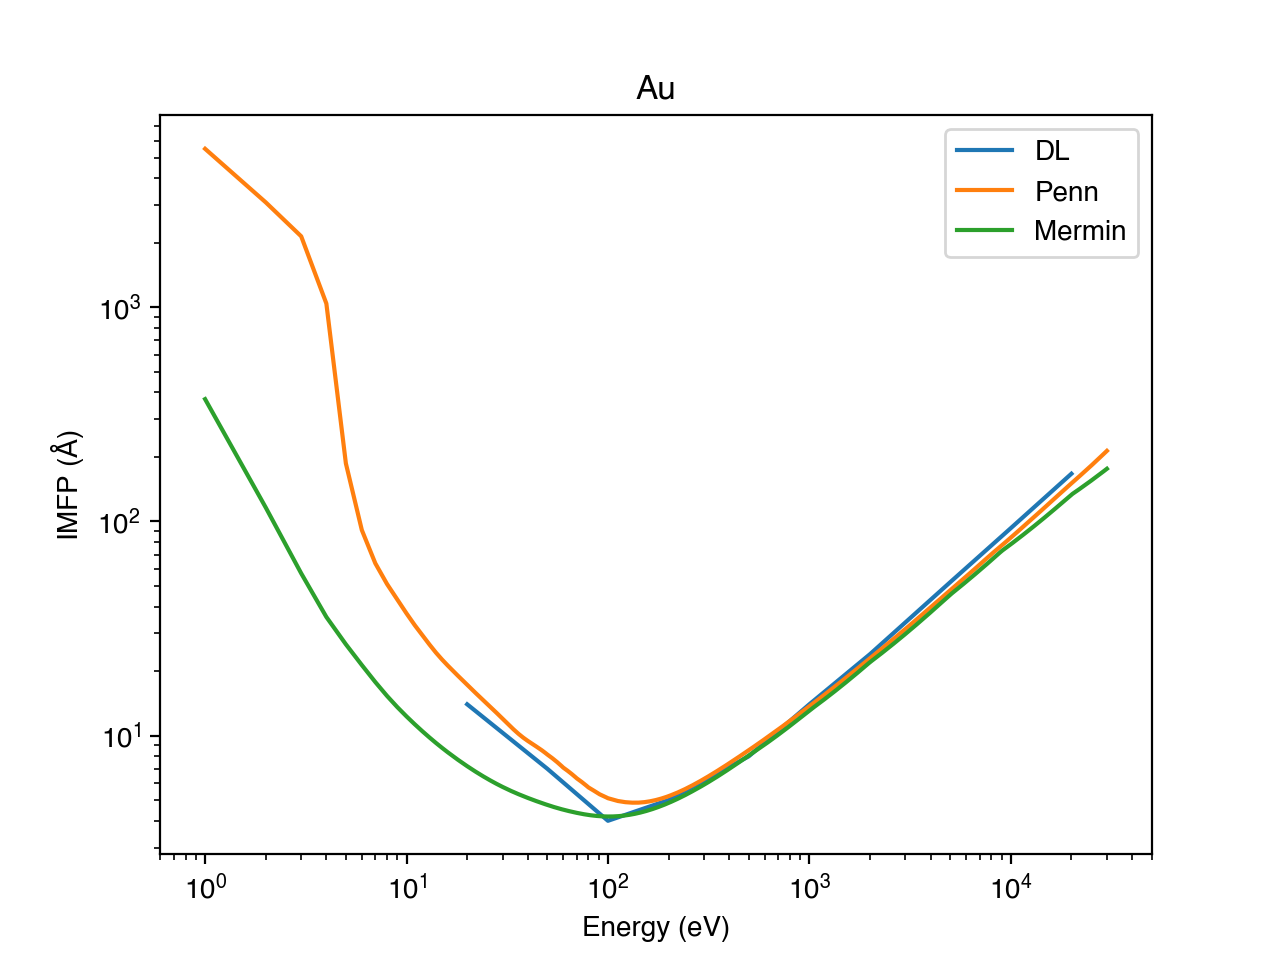

In [92]:
plt.figure()
plt.plot(E0, lin,label='DL')
plt.plot(au_iimfp[:,0],au_iimfp[:,10],label='Penn')
plt.plot(au_iimfp[:,0],au_iimfp[:,2],label='Mermin')
plt.xlabel('Energy (eV)')
plt.ylabel('IMFP ($\mathrm{\AA}$)')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.title(oscParams.name)
plt.show()